# Intro

In [1]:
#@title pre installations
'''
Updated 17.03.2025 after pandas / numpy issue.
Needs restart after!!
'''

import numpy as np

if np.__version__ != '1.26.4':
  !pip install "numpy==1.26.4" pandas==2.2.2 --force
else:
  import pandas as pd
  print("Correct numpy/pandas version installed!")

Correct numpy/pandas version installed!


In [2]:
#@title installations
'''
Updated 14.03.2025.
Might not be everything needed for full duneminds but should do for training and prediction.
'''

!pip uninstall -y tensorflow tensorflow-text tensorstore tf-keras dopamine-rl jax torch flax optax
!pip install --no-cache-dir tensorflow[and-cuda]==2.15.1
!pip install rasterio scikit-learn

Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Found existing installation: tensorstore 0.1.74
Uninstalling tensorstore-0.1.74:
  Successfully uninstalled tensorstore-0.1.74
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
Found existing installation: dopamine_rl 4.1.2
Uninstalling dopamine_rl-4.1.2:
  Successfully uninstalled dopamine_rl-4.1.2
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: flax 0.10.6
Uninstalling flax-0.10.6:
  Successfully uninstalled flax-0.10.6
Found existing installation: optax 0.2.4
Uninstalling optax-0.2.4:
  Successfully uninstalled optax-0.2.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 

In [3]:
#@title packages, common paths, mount drive

from matplotlib import pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from datetime import date, datetime
import os
import sys
import glob
import random
import csv
import shutil
import openpyxl
from openpyxl import load_workbook
from tqdm.notebook import tqdm
import seaborn as sns
import re
import json
import itertools as it
import string
from skimage.exposure import match_histograms


# keras & tensorflow
import tensorflow as tf
from tensorflow import keras


# geospatial
import rasterio
from rasterio.mask import mask
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
import geopandas as gpd
from osgeo import gdal, gdalconst
import folium
from folium import plugins
from pyproj import Transformer



# dune height & curvature
from scipy.ndimage import gaussian_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import white_tophat
from scipy.ndimage import median_filter



# training
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator #augmentation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import apply_affine_transform
from scipy.ndimage import distance_transform_edt
import matplotlib.colors as colors


# model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from tensorflow.keras.applications import ResNet50



## set seeds for tf and np
SEED = 42
os.environ["PYTHONASHSEED"] = str(SEED)
keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

## set date
date_today = date.today().strftime("%Y-%m-%d")
#date_time_today = datetime.now().strftime("%Y-%m-%d-%H-%M")


## mount google drive
from google.colab import drive
drive.mount("/content/drive")


## common paths
HOME_PATH = "/content/drive/MyDrive/DUNEMINDS_data" #@param{"type": "string"}
FUNCTIONS_SCRIPT_PATH = "/content/drive/MyDrive/Notebooks/DUNEMINDS_scripts/model_1_functions.py" #@param{"type": "string"}
HOME_PATH_2 = "/content/drive/MyDrive/PAPER3_data" #@param{"type": "string"}



Mounted at /content/drive


In [4]:
#@title wandb login

import os
import wandb

os.environ["WANDB_API_KEY"] = "2ab14cc0a4b44bd2bcdb342dd693e83668c99b5b"
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Currently logged in as: maike-nowatzki (duneminds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
#@title wandb imports

from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger

In [6]:
#@title wandb init test

wandb.init(name="test", project="testinit", force=True, reinit=False)

wandb: Currently logged in as: maike-nowatzki (duneminds) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [7]:
#@title wandb finish
wandb.finish()

In [8]:
#@title helper functions



######### function to check if folder exists and contains a specific type of files ##########

def fun_check_folder_file(path, file_suffix):
  print(f"path: {path}")
  print(f"file suffix: {file_suffix}")


  stop_var_fun_check_folder_file = 0

  if os.path.exists(path):

    for files in os.listdir(path):
      if files.endswith(file_suffix):
        stop_var_fun_check_folder_file += 1

  else:
    print(path)
    sys.exit("STOP. Path not existing.")

  return stop_var_fun_check_folder_file


########## function to check if file exists ##########

def fun_check_file(path, file_suffix, path_and_file):

  stop_var_fun_check_file = 0

  for files in os.listdir(path):
    if files.endswith(file_suffix):
      stop_var_fun_check_file += 1

  if stop_var_fun_check_file == 0:
    with open(path_and_file, 'w'):
      pass
    print("File created.")

  else:
    print("File already existing.")



########## check if folder exists and contains files with prefix ##########

def fun_check_folder_file_pref(path, file_suffix, file_prefix):


  stop_var_fun_check_folder_file = 0

  if os.path.exists(path):

    for files in os.listdir(path):
      if files.endswith(file_suffix) and files.startswith(file_prefix):
        stop_var_fun_check_folder_file += 1

  else:
    sys.exit("STOP. Path not existing.")

  return stop_var_fun_check_folder_file




########## function to check if a folder exists and create it if it does not ##########

def fun_check_create_folder(path):

  if os.path.exists(path):
    print("Folder exists.")

  else:
    os.mkdir(path)
    print("Created folder.")

  return path


########## function that asks user for input on whether to continue even though files have already been created

def fun_exit_decision():


  def fun_exit_decision_input():

    exit_decision_input = input("Files already existing. Would you like to proceed anyway? (y/n)")

    return exit_decision_input


  exit_decision = fun_exit_decision_input()

  while exit_decision != 'y' and exit_decision != 'n':
    print("Wrong input. Try again!")
    exit_decision = fun_exit_decision_input()

  if exit_decision == 'y':
    print("Let's keep going!")

  elif exit_decision == 'n':
    sys.exit("Files already existing. You decided to stop.")




########## function to normalise tiles based on values of whole study area ##########
## pre-processing Sentinel-2 tiles and putting them into pp training folder as geotiff

def fun_normalisation(path_in,
                      normal,
                      min_max_creation,
                      path_download_images,
                      download_file_suffix,
                      csv_path_file,
                      file_suffix,
                      dt,
                      path_out,
                      name_out,
                      dataprep_data,
                      study_area_dataprep):


  images = os.listdir(path_in)

  if normal: #only if normalisation is required

    ## Retrieval of the min max values of the whole study area
    if min_max_creation: #only if there are no min & max values for the entiry study area saved

      download_images = os.listdir(path_download_images)

      for i, image_name in enumerate(download_images): #go through the image tiles downloaded from GEE
        if image_name.endswith(download_file_suffix) == True: #only consider those with a particular suffix


          with rasterio.open(path_download_images + '/' + image_name) as src: #open tiles
            for j, band in enumerate(range(1, src.count + 1)): #go through each band of the currently open tile
              df = pd.read_csv(csv_path_file, header=0, index_col=None) # read the csv file that holds the currently smalles min / largest max values
              old_min = df.iloc[j,0] # current min value of that band of a previous tile saved in csv
              #print(old_min)
              old_max = df.iloc[j,1] # current max value of that band of a previous tile saved in csv
              print(old_max)
              band_data = src.read(band) # read band

              min_value = np.nanmin(band_data) # calculate min value of the current tile / band
              #print(min_value)
              if min_value < old_min: # if current value is smaller than the saved old one - overwrite old
                df.iloc[j,0] = min_value

              max_value = np.nanmax(band_data) # calculate max value of the current tile / band
              print(max_value)
              if max_value > old_max: # if current value is larger than the saved old one - overwrite old
                df.iloc[j,1] = max_value

              df.to_csv(csv_path_file, index=False) # save new values to csv (overwrite)


    ## applying normalisation to training / vali / test data
    # read all images in folder holding original data
    for k, image_name in enumerate(images):
      if image_name.endswith(file_suffix) == True:
        print(image_name)
        img_pp = [] # empty list to store preprocessed array

        with rasterio.open(path_in + "/" + image_name) as src: # open original files
          for m, band in enumerate(range(1, src.count + 1)): # go through bands individually

            img_band = src.read(band) # read band as np array

            # check if GTiff has been converted to ndarray
            array_test = rasterio.dtypes.is_ndarray(img_band)
            if array_test == False:
              sys.exit("STOP. GTiff has not been converted to ndarray!")

            # convert to float if it isn't float already
            if dt != 'no_conversion':
              data_type = img_band.dtype
              #print(data_type)

            elif data_type != dt:
              img_band = img_band.astype('f4')

            df = pd.read_csv(csv_path_file, header=0, index_col=None) # read csv file with stored min max values of whole area
            band_min = np.nanmin(img_band) # calculate min max values for current tile / band
            band_max = np.nanmax(img_band)
            overall_min = df.iloc[m,0] # get min max values of whole study area for currently open band  from csv file
            overall_max = df.iloc[m,1]

            if band_min < 0 or band_max > 1: # check if currently open tile / band is already normalised to 0-1 range
              img_band_pp = (img_band - overall_min) / (overall_max - overall_min) # calculate NORMALISATION
              #print(img_band_pp)
              img_pp.append(np.array(img_band_pp)) # stack bands of each file to create multiband array

            else:
              img_pp.append(np.array(img_band)) # in case no normalisation is needed: just stack original arrays



            img_pp = np.array(img_pp) # create np array from img_pp list

            ## calculate parameters for export
            array_shape = img_pp.shape
            #print(array_shape)
            band_nr = array_shape[0]
            #print("band nr: ", band_nr)
            array_rows = array_shape[1]
            #print("rows: ", array_rows)
            array_columns = array_shape[2]
            #print("columns: ", array_columns)


            ## transformation into GeoTiff
            with rasterio.open(path_out + "/" + 'pp_' + study_area_dataprep + '_' + image_name,
                                'w',
                                driver='Gtiff',
                                width=array_rows,
                                height=array_columns,
                                count=band_nr,
                                crs=src.crs,
                                transform=src.transform,
                                dtype='float32'
                                ) as name_out:

              name_out.write(img_pp)

  elif normal == False: # in case no normalisation is required (e.g. for binary labels) just copy original data into pp folder

    for file_name in images:
      if file_name.endswith(file_suffix):
        src_file = os.path.join(path_in, file_name)
        dst_file = os.path.join(path_out, file_name)

        shutil.copy(src_file, dst_file)




########## function to create array dataset of single images ##########

def fun_array_dataset(path_images_in):

  count = 0 # counter
  dataset_out = [] # create empty dataset

  images_in = os.listdir(path_images_in) # go to path containing images

  # read all images in folder as arrays and append
  for i, image_name in enumerate(sorted(images_in)):
    if image_name.endswith('label.tif'):
      #print(image_name)
      image = rasterio.open(path_images_in + '/' + image_name)
      #show(image)
      image = image.read()
      image = image.transpose((1,2,0)) # order of dimensions is now size, size, bands
      #print(image)

      dataset_out.append(np.array(image))

      count += 1

      # counter
      #if count % 1 == 0:
        #print(count, " images added")

  #print(dataset_out)
  #print(images_in)
  print("SHAPE dataset:")
  print(dataset_out[1].shape)
  print("SIZE dataset:")
  print(len(dataset_out))


  # convert dataset (lists) to arrays
  #dataset_out = np.expand_dims(np.array(dataset_out), axis=1) # this is as done Sreeni's unet, but doesn't work here
  dataset_out = np.array(dataset_out)
  #print(dataset_out)
  print(dataset_out.shape) #number of tiffs, new axis, bands, size, size

  return dataset_out



########## function to create array dataset of single images ##########

def fun_downsample_array_dataset(path_images_in):

  count = 0 # counter
  dataset_out = [] # create empty dataset

  images_in = os.listdir(path_images_in) # go to path containing images

  # read all images in folder as arrays and append
  for i, image_name in enumerate(sorted(images_in)):
    if image_name.endswith('label.tif'):
      #print(image_name)
      with rasterio.open(os.path.join(path_images_in, image_name), "r") as src:
        image = src.read()
        profile = src.profile
        new_height = src.height // 3
        new_width = src.width // 3
        profile.update(width=new_width, height=new_height)

        # downscaling
        image_new = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )

        #print(image_new.shape)

      image_new = image_new.transpose((1,2,0)) # order of dimensions is now size, size, bands
      #print(image)

      dataset_out.append(np.array(image_new))

      count += 1

      # counter
      #if count % 1 == 0:
        #print(count, " images added")

  #print(dataset_out)
  #print(images_in)
  print("SHAPE dataset:")
  print(dataset_out[1].shape)
  print("SIZE dataset:")
  print(len(dataset_out))

  # convert dataset (lists) to arrays
  #dataset_out = np.expand_dims(np.array(dataset_out), axis=1) # this is as done Sreeni's unet, but doesn't work here
  dataset_out = np.array(dataset_out)
  #print(dataset_out)
  print(dataset_out.shape) #number of tiffs, new axis, bands, size, size

  return dataset_out




########## function to read and print csv ##########

def fun_read_csv(file_path):

  with open (file_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
      print(row)



########## function to get matching images from two folders and create a training dataset ##########

def fun_concatenate_img(paths):

  print("start concatenation")

  # get images from each folder, sort them and only choose tif files
  data = [] #empty list that will be filled with a list of all the datsets used

  for path in paths:
    # create list of lists - every list item (one directory) contains list of files
    data.append(sorted([file for file in os.listdir(path) if file.endswith('.tif')]))

  #print(data)

  dataset_out = [] #create empty dataset

  if len(set([len(item) for item in data])) > 1: #make sure that the same number of images is in both folders
    sys.exit('stop, different number of images per image type.')

  for i in range(len(data[0])): # goes through every item in data (each item is a list of files)

    img_list = [] #empty list that will be filled with rasterio.open commands for every  image

    for path in paths:

      img_path = path + '/' + data[paths.index(path)][i]

      print(img_path)

      # read and transpose image
      img = rasterio.open(img_path).read().transpose((1,2,0))


      # Exclude blue channel if input data is more than two items (e.g. optical and DEM) AND one of them is optical 4 channel
      num_channels = img.shape[2]
      if len(paths) > 1 and num_channels == 4:
        img = img[:,:,[0,1,3]] #select R, G, NIR - excluding Blue channel


      img_list.append(img) # add to list that will later be used for concatenation



    # concatenate each single images - stack them on top of each other to create one more img channel
    conc_image = np.concatenate(img_list, axis = 2)

    # add concatenated image to training image stack
    dataset_out.append(np.array(conc_image))


  dataset_out = np.array(dataset_out)


  dataset_info = []  # List to store (path, file_name) tuples

  for path in paths:

    for i in range(len(data[0])):

      # Store the folder path and file name as a tuple
      dataset_info.append((path, data[paths.index(path)][i]))




  return dataset_out, dataset_info




########## function to get matching images from two folders and create a training dataset ##########

def fun_downsample_concatenate_img(paths):

  # get images from each folder, sort them and only choose tif files
  data = [] #empty list that will be filled with a list of all the datsets used

  for path in paths:
    # create list of lists - every list item (one directory) contains list of files
    data.append(sorted([file for file in os.listdir(path) if file.endswith('.tif')]))

  dataset_out = [] #create empty dataset

  if len(set([len(item) for item in data])) > 1: #make sure that the same number of images is in both folders
    sys.exit('stop, different number of images per image type.')

  for i in range(len(data[0])): # goes through every item in data (each item is a list of files)

    img_list = [] #empty list that will be filled with rasterio.open commands for every  image

    for path in paths:

      img_path = path + '/' + data[paths.index(path)][i]

      # read and transpose image
      img = rasterio.open(img_path).read().transpose((1,2,0))

      with rasterio.open(img_path, "r") as src:
        img = src.read()
        profile = src.profile
        new_height = src.height // 3
        new_width = src.width // 3
        profile.update(width=new_width, height=new_height)

        img_new = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )

      img_new = img_new.transpose((1,2,0))

      # Exclude blue channel if input data is more than two items (e.g. optical and DEM) AND one of them is optical 4 channel
      num_channels = img_new.shape[2]
      if len(paths) > 1 and num_channels == 4:
        img_new = img_new[:,:,[0,1,3]] #select R, G, NIR - excluding Blue channel


      img_list.append(img_new) # add to list that will later be used for concatenation


    # concatenate each single images - stack them on top of each other to create one more img channel
    conc_image = np.concatenate(img_list, axis = 2)

    # add concatenated image to training image stack
    dataset_out.append(np.array(conc_image))


  dataset_out = np.array(dataset_out)

  dataset_info = []  # List to store (path, file_name) tuples

  for path in paths:

    for i in range(len(data[0])):

      # Store the folder path and file name as a tuple
      dataset_info.append((path, data[paths.index(path)][i]))


  return dataset_out, dataset_info




########## function to save .py file as .txt file ##########

def save_py_txt(input_path: str, output_path: str):
  # Read the Python script
  with open(input_path, 'r') as file:
    script_content = file.read()

    # Save the script content into a text file
    with open(output_path, 'w') as file:
      file.write(script_content)



########## Function to create and add important input and result data to spreadsheet ##########

def workbook_creation_addition(path, variables):


  # Load the existing workbook or create a new one
  try:
    workbook = load_workbook(path)
  except FileNotFoundError:
    workbook = openpyxl.Workbook()

  # Select the active sheet
  sheet = workbook.active


  # Determine the next available row
  next_row = sheet.max_row + 1

  # Add header row if the sheet is empty
  if sheet.max_row == 1:
    header_row = ['RUN_ID',
                'DATE',
                'OPTIMIZER',
                'LOSS',
                'METRIC',
                'ACTIVATION_1',
                'ACTIVATION_2',
                'DATA',
                'STUDY_AREA',
                'TRAIN_VALI_SPLIT',
                'AUGMENT_DECISION',
                'ROTATION_RANGE',
                'WIDTH_SHIFT',
                'HEIGHT_SHIFT',
                'ZOOM_RANGE',
                'HORIZONTAL_FLIP',
                'VERTICAL_FLIP',
                'BRIGHTNESS_RANGE',
                'FILL_MODE',
                'BRIGHTNESS_RANDOM_RANGE',
                'TILE_SIZE_TRAIN',
                'BATCH_SIZE',
                'EPOCH_NR',
                'SHUFFLE_TRAIN',
                'EPOCH_MONITOR',
                'EPOCH_PATIENCE',
                'STEPS_PER_EPOCH',
                'MONITOR_BESTWEIGHT',
                'PRED_THRESHOLD',
                'PRE_TRAIN_DECISION',
                'PRE_TRAIN_RUN',
                'EPOCHS_RUN',
                'BEST_EPOCH_LOSS',
                'BEST_EPOCH_VAL_LOSS',
                'BEST_EPOCH_ACC',
                'BEST_EPOCH_VAL_ACC',
                'IOU',
                'AVG_TRUE_POS',
                'AVG_FALSE_POS',
                'AVG_TRUE_NEG',
                'AVG_FALSE_NEG'
                ]
    sheet.append(header_row)


  # Append variables to the next row in the spreadsheet
  sheet.append(variables)

  # Save the modified spreadsheet
  workbook.save(path)



########## normalising images for plotting when their values are too close to each other to display as different values ##########

def plot_normalisation(image):

  image = np.array(image)

  unique_values = np.unique(image) #calculates every value occuring in the image

  a = 0.01
  b = 0.99

  if len(unique_values) == 1:
    # If the image contains only one unique value, set default values for min_val and max_val
    min_val = 0
    max_val = 1


  else:

    has_zero = np.any(unique_values == 0) #if zeros occur: has_zero
    has_one = np.any(unique_values == 1) #if ones occur: has_one


    if has_zero:
      min_val = unique_values[1] # zeros are turned into second lowest number

    else:
      min_val = unique_values[0]


    if has_one:
      max_val = unique_values[-2] #ones are turned into second highest number

    else:
      max_val = unique_values[-1]


  normalised_image = a + ((image - min_val) * (b - a)) / (max_val - min_val) #normalisation with min_val being stretched to 0.01 and max_val being stretched to 0.99

  normalised_image = np.clip(normalised_image, 0, 1)


  return normalised_image




########## function to get variables from txt file ##########

def get_list_var_from_txt(path, line_start):
  variable = None
  found_line = False

  with open(path, 'r') as file:
    for line in file:
      if line.startswith(line_start):
        variable = line[line.find("[")+1:line.find("]")] #extracts everything between the brackets
        print(variable)
        list_var = eval('[' + variable + ']') #adds brackets and creates list
        found_line = True
        break

  if not found_line:
    list_var = ['largest']

  return list_var


########## function to figure out what files are training and what are validation data after split ##########
def fun_identify_train_vali_files(path_train_csv, path_vali_csv, train_dataset, X_train, X_vali, train_image_info):

  # Find indices of images in X_train and X_vali within the concatenated dataset
  train_indices = [np.where((train_dataset == data).all(axis=(1, 2, 3)))[0][0] for data in X_train]
  vali_indices = [np.where((train_dataset == data).all(axis=(1, 2, 3)))[0][0] for data in X_vali]


  # Find corresponding image information for X_train and X_vali
  train_image_info_selected = [train_image_info[idx] for idx in train_indices]
  vali_image_info_selected = [train_image_info[idx] for idx in vali_indices]

  #print("Training image info:", train_image_info_selected)
  #print("Validation image info:", vali_image_info_selected)


  # Saving image information for X_train to a CSV file
  #with open('/soge-home/users/hert6209/model_1_data/csv/train_image_info.csv', 'w', newline='') as csvfile:
  with open(path_train_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Folder Path', 'File Name'])
    csv_writer.writerows(train_image_info_selected)

  # Saving image information for X_vali to a CSV file
  #with open('/soge-home/users/hert6209/model_1_data/csv/vali_image_info.csv', 'w', newline='') as csvfile:
  with open(path_vali_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Folder Path', 'File Name'])
    csv_writer.writerows(vali_image_info_selected)




########## function to prepare very large image to be plotted including reprojection ##########



def prep_plot_large_image(downscale_factor, path):

  with rasterio.open(path) as src:

    data = dataset.read(
        out_shape=(
            src.count,
            int(src.height * downscale_factor),
            int(src.width * downscale_factor)
        ),
        resampling=Resampling.bilinear

    )

    # scale image transform
    transform = src.transform * src.transform.scale(
      (src.width / data.shape[-1]),
      (src.height / data.shape[-2])
  )


  # Extract color channels
  img_blue = data[0, :, :]
  img_green = img_orig[1, :, :]
  img_red = img_orig[2, :, :]

  # Stack the channels
  img = np.stack([img_red, img_green, img_blue], axis=-1)

  # Print the shape of the resampled image
  print(img.shape)

  return img


In [9]:
#@title GPU check

!nvidia-smi

print(tf.sysconfig.get_build_info()['cuda_version'])

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ GPU found and configured!")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found, training on CPU.")


Sat May 10 13:39:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Training

In [10]:
#@title custom metrics

def iou(y_true, y_pred):
  smooth = 1
  y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
  iou_score = (intersection + smooth) / (union + smooth)
  iou_score = iou_score
  return iou_score

def iou_metric(y_true, y_pred):
  return iou(y_true, y_pred)


def tiou(y_true, y_pred):

  c = tf.constant(0.5)

  w = tf.ones([3,3,1,1], dtype=tf.dtypes.float32)

  y_true = tf.cast(tf.greater_equal(y_true, prediction_threshold), tf.float32)  # Apply thresholding
  y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding

  y_true_conv = tf.nn.convolution(y_true, w, padding="SAME", strides=1)>=1
  y_pred_conv = tf.nn.convolution(y_pred, w, padding="SAME", strides=1)>=1

  y_true_conv = tf.cast(y_true_conv, dtype=tf.dtypes.float32)
  y_pred_conv = tf.cast(y_pred_conv, dtype=tf.dtypes.float32)


  y_true_tiered = (y_true_conv * c) + (y_true * c)

  y_pred_tiered = (y_pred_conv * c) + (y_pred * c)


  intersection_full = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 1.0, y_pred_tiered == 1.0),
                                    tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 0.5))

  intersection_full = tf.cast(intersection_full, tf.float32)

  intersection_lim_1 = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 1.0),
                                   tf.math.logical_and(y_true_tiered == 1.0, y_pred_tiered == 0.5))

  intersection_lim_1 = tf.cast(intersection_lim_1, tf.float32)

  intersection_lim_2 = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 0.0, y_pred_tiered == 0.5),
                                   tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 0.0))

  intersection_lim_2 = tf.cast(intersection_lim_2, tf.float32)

  union_tiered = tf.math.logical_or(y_true_tiered != 0.0, y_pred_tiered != 0.0)

  union_tiered = tf.cast(union_tiered, tf.float32)

  intersection_total = tf.math.reduce_sum(intersection_full) + (tf.math.reduce_sum(intersection_lim_1) * 0.5) + (tf.math.reduce_sum(intersection_lim_2) * 0.5)
  union_total = tf.math.reduce_sum(union_tiered)

  iou_tiered = intersection_total / union_total

  return iou_tiered

@keras.saving.register_keras_serializable()
def tiou_metric(y_true, y_pred):
  return tiou(y_true, y_pred)



def false_positive(y_true, y_pred):
  y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding
  intersection = tf.reduce_sum(y_true * y_pred)
  false_positive_score = intersection + 0.0000001 / y_true + 0.0000001
  return false_positive_score

def false_positive_metric(y_true, y_pred):
  return false_positive(y_true, y_pred)

In [11]:
#@title test tiou

# def tiou(y_true, y_pred):

#   c = tf.constant(0.5)

#   w = tf.ones([3,3,1,1], dtype=tf.dtypes.float32)

#   y_true = tf.cast(tf.greater_equal(y_true, prediction_threshold), tf.float32)  # Apply thresholding
#   y_pred = tf.cast(tf.greater_equal(y_pred, prediction_threshold), tf.float32)  # Apply thresholding

#   y_true_conv = tf.nn.convolution(y_true, w, padding="SAME", strides=1)>=1
#   y_pred_conv = tf.nn.convolution(y_pred, w, padding="SAME", strides=1)>=1

#   y_true_conv = tf.cast(y_true_conv, dtype=tf.dtypes.float32)
#   y_pred_conv = tf.cast(y_pred_conv, dtype=tf.dtypes.float32)


#   y_true_tiered = (y_true_conv * c) + (y_true * c)

#   y_pred_tiered = (y_pred_conv * c) + (y_pred * c)


#   intersection_full = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 1.0, y_pred_tiered == 1.0),
#                                     tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 0.5))

#   intersection_full = tf.cast(intersection_full, tf.float32)

#   intersection_lim_1 = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 1.0),
#                                    tf.math.logical_and(y_true_tiered == 1.0, y_pred_tiered == 0.5))

#   intersection_lim_1 = tf.cast(intersection_lim_1, tf.float32)

#   intersection_lim_2 = tf.math.logical_or(tf.math.logical_and(y_true_tiered == 0.0, y_pred_tiered == 0.5),
#                                    tf.math.logical_and(y_true_tiered == 0.5, y_pred_tiered == 0.0))

#   intersection_lim_2 = tf.cast(intersection_lim_2, tf.float32)

#   union_tiered = tf.math.logical_or(y_true_tiered != 0.0, y_pred_tiered != 0.0)

#   union_tiered = tf.cast(union_tiered, tf.float32)

#   intersection_total = tf.math.reduce_sum(intersection_full) + (tf.math.reduce_sum(intersection_lim_1) * 0.75) + (tf.math.reduce_sum(intersection_lim_2) * 0.5)
#   union_total = tf.math.reduce_sum(union_tiered)

#   iou_tiered = intersection_total / union_total

#   return iou_tiered

# # Create a four-dimensional tensor of zeros
# tensor1 = np.zeros((96, 96, 1, 1))

# # Fill the diagonal with ones
# np.fill_diagonal(tensor1[:, :, 0, 0], 1)

# # Create a second tensor identical to the first one
# tensor2 = np.copy(tensor1)

# shape = (96, 96, 1, 1)

# # Create a tensor of zeros
# tensor2 = np.zeros(shape)

# # Set values along the diagonal line
# for i in range(min(shape[0], shape[1])-1):
#     tensor2[i, i+1, 0, 0] = 1


# prediction_threshold = 0.5


# iou_result = tiou(tensor1, tensor2)

# tensor1 = tensor1.reshape(tensor1.shape[0], -1)
# tensor2 = tensor2.reshape(tensor2.shape[0], -1)

# # Plot the tensor
# plt.imshow(tensor1, cmap='binary')
# plt.title('Tensor 1')
# plt.colorbar()
# plt.show()
# print(iou_result)

# # Plot the tensor
# plt.imshow(tensor2, cmap='binary')
# plt.title('Tensor 2')
# plt.colorbar()
# plt.show()
# print(iou_result)

In [12]:
#@title model functions


########## UNET MODEL SMALL ########## smallest 48x48

def unet_model_small(img_height, img_width, img_bands, seed, optimizer, metric, prediction_threshold):
  keras.utils.set_random_seed(seed)
  inputs = Input((None, None, img_bands))
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  c1 = Dropout(0.1)(c1)

  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  print(tf.shape(c1))
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  c2 = Dropout(0.1)(c2)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  ## new
  c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c5 = BatchNormalization()(c5)
  c5 = Activation(activation_1)(c5)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c5)

  ### expansive


  ## new
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
  u8 = concatenate([u8, c2])
  u8 = BatchNormalization()(u8)  # Add batch normalization after up-sampling
  u8 = Activation(activation_1)(u8)

  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = BatchNormalization()(c8)  # Add batch normalization after up-sampling
  c8 = Activation(activation_1)(c8)
  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)


  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = BatchNormalization()(u9)
  u9 = Activation(activation_1)(u9)

  c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = BatchNormalization()(c9)
  c9 = Activation(activation_1)(c9)
  c9 = Conv2D(16, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation=activation_2)(c9)

  model = Model(inputs=[inputs], outputs=[outputs])



  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  # elif metric == "tiou_metric":
  #   model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.compile(optimizer=optimizer, loss=loss, metrics=metric)
  #model.summary()

  return model



########## UNET MODEL MEDIUM ########## smallest 12x12

def unet_model_medium(img_height, img_width, img_bands, seed, optimizer, metric, prediction_threshold):
  keras.utils.set_random_seed(seed)
  inputs = Input((None, None, img_bands))
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  c1 = Dropout(0.1)(c1)

  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  print(tf.shape(c1))
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  c2 = Dropout(0.1)(c2)

  c2 = Conv2D(32, (3, 3),  kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  c3 = Dropout(0.2)(c3)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  p3 = MaxPooling2D((2, 2))(c3)


  c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c5 = BatchNormalization()(c5)
  c5 = Activation(activation_1)(c5)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c5)


  # #Expansive path
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
  u7 = concatenate([u7, c3])
  u7 = BatchNormalization()(u7)  # Add batch normalization after up-sampling
  u7 = Activation(activation_1)(u7)

  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = BatchNormalization()(c7)  # Add batch normalization after up-sampling
  c7 = Activation(activation_1)(c7)
  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)


  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  u8 = BatchNormalization()(u8)  # Add batch normalization after up-sampling
  u8 = Activation(activation_1)(u8)

  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = BatchNormalization()(c8)  # Add batch normalization after up-sampling
  c8 = Activation(activation_1)(c8)
  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)


  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = BatchNormalization()(u9)
  u9 = Activation(activation_1)(u9)

  c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = BatchNormalization()(c9)
  c9 = Activation(activation_1)(c9)
  c9 = Conv2D(16, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation=activation_2)(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  elif metric == "tiou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.summary()

  return model




########## UNET MODEL LARGE ##########

def unet_model_large(img_height, img_width, img_bands, seed, optimizer, metric, prediction_threshold):

  keras.utils.set_random_seed(seed)
  inputs = Input((None, None, img_bands))
  s = inputs

  dropout_value_1 = 0.1
  dropout_value_2 = 0.2
  dropout_value_3 = 0.3

  #Contraction path
  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(s) #padding=same means output size is same dimeansions as input
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  c1 = Dropout(dropout_value_1)(c1) #random deactivation of neurons to prevent overfitting

  c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  c1 = Activation(activation_1)(c1)
  print(tf.shape(c1))
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  c2 = Dropout(dropout_value_1)(c2)

  c2 = Conv2D(32, (3, 3),  kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  c2 = Activation(activation_1)(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  c3 = Dropout(dropout_value_2)(c3)

  c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
  c3 = BatchNormalization()(c3)
  c3 = Activation(activation_1)(c3)
  p3 = MaxPooling2D((2, 2))(c3)


  c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c4 = BatchNormalization()(c4)
  c4 = Activation(activation_1)(c4)
  c4 = Dropout(dropout_value_2)(c4)

  c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
  c4 = BatchNormalization()(c4)
  c4 = Activation(activation_1)(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)


  c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
  c5 = BatchNormalization()(c5)
  c5 = Activation(activation_1)(c5)
  c5 = Dropout(dropout_value_3)(c5)
  c5 = Conv2D(256, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c5)



  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  u6 = BatchNormalization()(u6)  # Add batch normalization after up-sampling
  u6 = Activation(activation_1)(u6)

  c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(dropout_value_2)(c6)
  c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
  c6 = BatchNormalization()(c6)  # Add batch normalization after up-sampling
  c6 = Activation(activation_1)(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
  u7 = concatenate([u7, c3])
  u7 = BatchNormalization()(u7)  # Add batch normalization after up-sampling
  u7 = Activation(activation_1)(u7)

  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(dropout_value_2)(c7)
  c7 = BatchNormalization()(c7)  # Add batch normalization after up-sampling
  c7 = Activation(activation_1)(c7)
  c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  u8 = BatchNormalization()(u8)  # Add batch normalization after up-sampling
  u8 = Activation(activation_1)(u8)

  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(dropout_value_1)(c8)
  c8 = BatchNormalization()(c8)  # Add batch normalization after up-sampling
  c8 = Activation(activation_1)(c8)
  c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)


  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  u9 = BatchNormalization()(u9)
  u9 = Activation(activation_1)(u9)

  c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(dropout_value_1)(c9)
  c9 = BatchNormalization()(c9)
  c9 = Activation(activation_1)(c9)
  c9 = Conv2D(16, (3, 3), activation=activation_1, kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(1, (1, 1), activation=activation_2)(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  elif metric == "tiou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.summary()

  return model


########## RESNET MODEL ##########
'''
Resnet only works with 3 bands!!
'''


# Resnet backbone
def unet_model_resnet(tile_size, _, band_nr, SEED, optimizer, metric, prediction_threshold):
  assert band_nr == 3, "ResNet backbone only supports 3 bands"

  input_tensor = Input(shape=(None, None, 3))
  base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

  # Fine-tune only the deeper layers (conv4, conv5 blocks)
  for layer in base_model.layers:
      if "conv5" in layer.name or "conv4" in layer.name:
          layer.trainable = True
      else:
          layer.trainable = False

  # Feature maps from ResNet
  skip1 = base_model.get_layer("conv1_relu").output
  skip2 = base_model.get_layer("conv2_block3_out").output
  skip3 = base_model.get_layer("conv3_block4_out").output
  skip4 = base_model.get_layer("conv4_block6_out").output
  bridge = base_model.get_layer("conv5_block3_out").output

  def decoder_block(x, skip, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, skip])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

  d1 = decoder_block(bridge, skip4, 512)
  d2 = decoder_block(d1, skip3, 256)
  d3 = decoder_block(d2, skip2, 128)
  d4 = decoder_block(d3, skip1, 64)

  d5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d4)
  d5 = BatchNormalization()(d5)
  d5 = Activation('relu')(d5)
  d5 = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(d5)
  d5 = BatchNormalization()(d5)
  d5 = Activation('relu')(d5)

  output = Conv2D(1, (1, 1), activation='sigmoid')(d5)
  model = Model(inputs=input_tensor, outputs=output)

  ########## compile model using custom or keras loss / accuracy metric ##########

  if metric == "iou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[iou_metric])

  elif metric == "tiou_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[tiou_metric])

  elif metric == "false_positive_metric":
    model.compile(optimizer=optimizer, loss=loss, metrics=[false_positive_metric])

  else:
    all_metrics = []
    for th in np.linspace(0.3, 0.8, 6):
      all_metrics.append(tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=th, name = f"binary_iou_{th}" if th!=0.5 else "binary_iou"))

      all_metrics.append(tf.keras.metrics.TruePositives(thresholds=th, name = f"true_positives_{th}"))
      all_metrics.append(tf.keras.metrics.FalsePositives(thresholds=th, name = f"false_positives_{th}"))

    all_metrics.append(tiou_metric)
    all_metrics.append(tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name = "ROC"))

    # model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=prediction_threshold, name = "binary_iou")])

    model.compile(optimizer=optimizer, loss=loss, metrics=all_metrics)

  #model.summary()

  return model

In [13]:
#@title tiered IoU functions (and example)


########## function to calculate buffer(s) ##########


def simple_buffer(arr, extension_nr, tier_round):

  instances = arr.shape[0]
  rows = arr.shape[1]
  cols = arr.shape[2]

  if arr.dtype != np.float32:  # Check if the array is not already of float type
    result = arr.astype(np.float32)  # Convert the array to float
  else:
    result = np.copy(arr)  # Create a copy of the float array

  for i in range(instances):

    for row in range(rows):

      for col in range(cols):

        if arr[i, row, col] == 0:
          # Check 8-way neighborhood
          for r in range(row - extension_nr, row + extension_nr + 1):
            for c in range(col - extension_nr, col + extension_nr + 1):
              if (0 <= r < rows) and (0 <= c < cols) and arr[i, r, c] == 1: #checks if the neighbouring cells are 1 and that the row index is within the bounds of the array's row
                if tier_round == 1:
                  result[i, row, col] = 2
                elif tier_round == 2:
                  result[i, row, col] = 3

  return result



########## function to calculate tiered IoU ##########

def calculate_tiered_iou(tier_value_1: float, tier_value_2: float, prediction_data, ground_truth_data, extension_1, extension_2, second_tier_decision):

  prediction_data_upd = simple_buffer(prediction_data, extension_1, tier_round=1)
  ground_truth_data_upd = simple_buffer(ground_truth_data, extension_1, tier_round=1)

  if second_tier_decision:
    prediction_data_upd = simple_buffer(prediction_data_upd, extension_2, tier_round=2)
    ground_truth_data_upd = simple_buffer(ground_truth_data_upd, extension_2, tier_round=2)

  print(prediction_data_upd.shape)

  # Calculating full intersection
  intersection_full = np.logical_or.reduce([
      np.logical_and(prediction_data_upd == 1.0, ground_truth_data_upd == 1.0),
      np.logical_and(prediction_data_upd == 2.0, ground_truth_data_upd == 2.0),
      np.logical_and(prediction_data_upd == 3.0, ground_truth_data_upd == 3.0)
  ]) #reduce needed because logical_or can only take two arguments


  # calculating limited intersections
  intersection_lim_1 = (
      (prediction_data_upd == 1.0) & (ground_truth_data_upd == 2.0) |
      (prediction_data_upd == 2.0) & (ground_truth_data_upd == 1.0) |
      (prediction_data_upd == 2.0) & (ground_truth_data_upd == 3.0) |
      (prediction_data_upd == 3.0) & (ground_truth_data_upd == 2.0)
  )

  intersection_lim_2 = np.logical_or(np.logical_and(prediction_data_upd == 1.0, ground_truth_data_upd == 3.0),
                                   np.logical_and(prediction_data_upd == 3.0, ground_truth_data_upd == 1.0))

  # calculating union
  union_tiered = np.logical_or(prediction_data_upd != 0, ground_truth_data_upd != 0)
  pred_nonzero = prediction_data_upd != 0
  gt_nonzero = ground_truth_data_upd != 0
  pred_unique = np.unique(prediction_data_upd)
  gt_unique = np.unique(ground_truth_data_upd)

  # print(f"prediction non zeros: {pred_nonzero.sum()}")
  # print(f"ground truth non zeros: {gt_nonzero.sum()}")
  # print(f"prediction unique values: {pred_unique}")
  # print(f"ground truth unique values: {gt_unique}")


  # calculating iou
  IoU_tiered = (np.sum(intersection_full) + ((np.sum(intersection_lim_1))* tier_value_1) + ((np.sum(intersection_lim_2)) * tier_value_2)) / np.sum(union_tiered)

  print('first tier value: ', tier_value_1)
  print('second tier value: ', tier_value_2)

  print('mean intersection_full: ', np.mean(intersection_full))
  print('sum intersection_full: ', np.sum(intersection_full))
  print('mean intersection_lim_1: ', np.mean(intersection_lim_1))
  print('sum intersection_lim_1: ', np.sum(intersection_lim_1))
  print('mean intersection_lim_2: ', np.mean(intersection_lim_2))
  print('sum intersection_lim_2: ', np.sum(intersection_lim_2))
  print('mean union_tiered: ', np.mean(union_tiered))
  print('sum union_tiered: ', np.sum(union_tiered))
  print('IoU_tiered: ', IoU_tiered)
  # print("Unique values in prediction:", np.unique(prediction_data_upd, return_counts=True))
  # print("Unique values in ground truth:", np.unique(ground_truth_data_upd, return_counts=True))

  # print("Total full intersection:", np.sum(intersection_full))


  return IoU_tiered, prediction_data_upd, ground_truth_data_upd


# ## run test example

# %matplotlib inline

# extension_1 = 1 # 1 = only neighbouring cells; 2 = 2 neighbouring cells etc
# tier_value_1 = 1.0
# extension_2 = 3 # runs FIRST!!! This needs to be the bigger value
# tier_value_2 = 0.5

# second_tier_decision = True

# file_1 = os.path.join(HOME_PATH, "kalahari", "pp_data", "train_pp", "labels", "kalahari_tile_56640_69120_cr-label.tif")
# file_2 = os.path.join(HOME_PATH, "kalahari", "pp_data", "train_pp", "labels", "kalahari_tile_53568_62208_cr-label.tif")

# ## Displaying original + buffered image for file_1

# # display original
# with rasterio.open(file_1) as src:
#   img = src.read(1)
#   print("img shape")
#   print(img.shape)
# # plt.imshow(img)
# # plt.show()

# # buffering
# img = np.expand_dims(img, axis=0)
# img_upd = simple_buffer(img, extension_1, 1)
# img_upd_2 = simple_buffer(img, extension_2, 2)
# img_upd = np.squeeze(img_upd)
# img_upd_2 = np.squeeze(img_upd_2)

# # Define custom colors for values 0 to 5
# colors = ['black', 'red', 'blue', 'green', 'yellow', 'purple']  # Adjust as needed
# cmap = ListedColormap(colors)

# # # display buffer
# # plt.imshow(img_upd, cmap=cmap, vmin=0.0, vmax=5.0)
# # plt.colorbar()
# # plt.show()

# # # display buffer
# # plt.imshow(img_upd_2, cmap=cmap, vmin=0.0, vmax=5.0)
# # plt.colorbar()
# # plt.show()



# ## running test tIoU with two images

# # opening images
# with rasterio.open(file_1) as src:
#   img_1 = src.read(1)

# with rasterio.open(file_2) as src:
#   img_2 = src.read(1)

# # running IoU
# img_1 = np.expand_dims(img_1, axis=0)
# img_2 = np.expand_dims(img_2, axis=0)

# iou, prediction_img_upd, ground_truth_img_upd = calculate_tiered_iou(tier_value_1, tier_value_2, img_1, img_1, extension_1, extension_2, second_tier_decision)

# # display updated img
# prediction_img_upd = np.squeeze(prediction_img_upd)
# plt.imshow(prediction_img_upd, cmap=cmap, vmin=0, vmax=5)
# plt.colorbar()
# plt.show()

# # display buffer
# ground_truth_img_upd = np.squeeze(ground_truth_img_upd)
# plt.imshow(ground_truth_img_upd, cmap=cmap, vmin=0, vmax=5)
# plt.colorbar()
# plt.show()


In [14]:
#@title dataset preparation / augmentation functions


########## create list of folders that will be part of training / validation data ##########

def create_training_dir_list(home_dir,
                             study_area_train,
                             include_sentinel,
                             include_dem,
                             include_curv,
                             include_curv_smooth,
                             include_dune_height,
                             include_binary):

  selected_parameters = []
  list_paths_train_pp_img = []

  parameters = {
      "sentinel": include_sentinel,
      "dem": include_dem,
      "curv": include_curv,
      "curv_smooth": include_curv_smooth,
      "dune_height": include_dune_height,
      "binary": include_binary
  }

  include_dem = {
  }

  print(include_dem)

  for input_param, value in parameters.items():
    if value:
      selected_parameters.append(input_param)

  print(selected_parameters)

  if len(selected_parameters) > 4:
    sys.exit("Too many input data parameters selected. Cannot choose more than 4.")

  list_paths_train_pp_img = []
  for item in selected_parameters:
    paths_train_pp_img = os.path.join(home_dir, study_area_train, "pp_data", "train_pp", item) # LIST of paths
    list_paths_train_pp_img.append(paths_train_pp_img)

  return list_paths_train_pp_img




########## create one dataset of all training/validation images and labels + split into training and validation data ##########

def dataset_prep_split(list_paths_train_pp_img,
                      path_train_pp_lab,
                      test_size_number,
                      split_random_state,
                      path_train_csv,
                      path_vali_csv,
                      downsampling_yes):

  ## TRAINING IMAGES
  print("TRAINING IMAGES: ")
  if downsampling_yes:
    train_dataset, train_image_info = fun_downsample_concatenate_img(list_paths_train_pp_img)
  else:
    train_dataset, train_image_info = fun_concatenate_img(list_paths_train_pp_img)

  print(train_dataset.shape)
  size_dataset = train_dataset.shape[0]

  ## LABELS
  print("LABELS: ")
  if downsampling_yes:
    label_dataset = fun_downsample_array_dataset(path_train_pp_lab)
  else:
    label_dataset = fun_array_dataset(path_train_pp_lab) ## !! crestline vs dune body labels!!

  print(label_dataset.shape)

  # !! write down random_state when running as this ensures that data is only shuffled when random_state changes !!

  X_train, X_vali, y_train, y_vali = train_test_split(train_dataset, label_dataset, test_size = test_size_number, random_state = split_random_state)
  print("y_train - training labels")
  print(y_train.shape)
  print("y_vali - validation labels")
  print(y_vali.shape)
  print("X_train - training images")
  print(X_train.shape)
  print("X_vali - validation images")
  print(X_vali.shape)


  ## save files that are training vs validation as csv
  fun_identify_train_vali_files(path_train_csv, path_vali_csv, train_dataset, X_train, X_vali, train_image_info)


  return X_train, X_vali, y_train, y_vali



########## DATA AUGMENTATION ##########
# data gets exchanged with augmented images - creates more images



def augmentation(images,
                 labels,
                 seed,
                 augmentation_decision,
                 augment_batch_size,
                 rotation_range,
                 width_shift_range,
                 height_shift_range,
                 zoom_range,
                 horizontal_flip,
                 vertical_flip,
                 brightness_range_decision,
                 fill_mode,
                 label_mask_threshold):


  # ## custom pre-processing function to give every channel different brightness changes
  # def custom_brightness(img):

  #   # Generate random brightness factors for each channel
  #   brightness_factors = [np.random.uniform(low, high) for low, high in [brightness_range_values]]
  #   #brightness_factors = [np.random.uniform(brightness_range_values[0], brightness_range_values[1]) for _ in range(img.shape[-1])]
  #   #print(brightness_factors)

  #   # Apply brightness adjustment to each channel
  #   for i in range(img.shape[-1]):
  #     img[..., i] *= brightness_factors[i]

  #   # Make sure that image values are still within 0 and 1
  #   if np.any((img < 0.0) | (img > 1.0)):
  #     sys.exit('Some pixel values are outside the range of 0 and 1.')

  #   return img

  def custom_brightness(img):
    # Define the brightness range for each band separately
    lower_bound = 0.1
    upper_bound = 0.9

    # Generate a random brightness factor for each band
    brightness_factors = np.random.uniform(lower_bound, upper_bound, size=(img.shape[0],))

    # Apply brightness adjustment to each band
    for i in range(img.shape[-1]):
        img[..., i] *= brightness_factors[i]

    # Make sure that image values are still within 0 and 1
    #if np.any((img < 0.0) | (img > 1.0)):
        #sys.exit('Some pixel values are outside the range of 0 and 1.')

    return img


  if brightness_range_decision:

    img_data_gen_args = dict(rotation_range=rotation_range,
                        width_shift_range=width_shift_range, # value is percentage of image to shift
                        height_shift_range=height_shift_range,
                        zoom_range=zoom_range, # < 1 zooms in
                        horizontal_flip=horizontal_flip,
                        vertical_flip=vertical_flip,
                        #brightness_range=brightness_range,
                        fill_mode=fill_mode, # "constant", "nearest", "reflect" or "wrap"
                        preprocessing_function=custom_brightness,
                        cval=0)
                        #preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))#


  else:

    img_data_gen_args = dict(rotation_range=rotation_range,
                      width_shift_range=width_shift_range, # value is percentage of image to shift
                      height_shift_range=height_shift_range,
                      zoom_range=zoom_range, # < 1 zooms in
                      horizontal_flip=horizontal_flip,
                      vertical_flip=vertical_flip,
                      #brightness_range=None,
                      fill_mode=fill_mode, # "constant", "nearest", "reflect" or "wrap"
                      cval=0)
                      #preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))#,

  if augmentation_decision == True:

    img_generator = ImageDataGenerator(**img_data_gen_args)
    img_generator.fit(images, augment=True, seed=seed)
    img_generator = img_generator.flow(
                                    images,
                                    seed=seed,
                                    batch_size = augment_batch_size,
                                    shuffle = True)
                                    #save_to_dir = path_figures_sc + '/test_folder',
                                    #save_prefix = 'aug_img',
                                    #save_format = 'png')

    label_generator = ImageDataGenerator(**img_data_gen_args)
    label_generator.fit(labels, augment=True, seed=seed)
    label_generator = label_generator.flow(
                                    labels,
                                    seed=seed,
                                    batch_size = augment_batch_size,
                                    shuffle = True)
                                    #save_to_dir = path_figures_sc + '/test_folder',
                                    #save_prefix = 'aug_label',
                                    #save_format = 'png')


  elif augmentation_decision == False:

    img_generator = ImageDataGenerator()
    img_generator.fit(images, augment=False, seed=seed) #doesnt matter if augment = True or false as long as no img_data_gen_args in ImageDataGenerator
    img_generator = img_generator.flow(images, seed=seed, batch_size = augment_batch_size, shuffle = False)

    label_generator = ImageDataGenerator()
    label_generator.fit(labels, augment=False, seed=seed)
    label_generator = label_generator.flow(labels, seed=seed, batch_size = augment_batch_size, shuffle = False)


  data_generator = zip(img_generator, label_generator)


  def binarise_label(img, mask):
    mask = np.where(mask > label_mask_threshold, 1, 0) #to binarise labels!
    return img, mask

  for (img, mask) in data_generator:
    img, mask = binarise_label(img, mask)
    yield img, mask



  return data_generator




########## sanity check - map AUGMENTED training/validation images + labels if they match ##########

def sanity_check_yes_augmentation(train_generator, vali_generator, train_fig_path, sanity_check_save):

  ## TRAIN

  x, y = next(train_generator)

  num_bands = x.shape[3]

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  for i in range(x.shape[0]):
    image = x[i]
    label = y[i]

    #print(np.unique(label)) #print all unique values - should only be 0 or 1 or either for labels

    plt.figure(figsize=(12, 4))
    for j in range(num_bands):
      image_band = image[:,:,j]
      normalised_band = plot_normalisation(image_band)
      plt.subplot(1, num_bands+1, j+1)
      plt.imshow(normalised_band, cmap='gray')
      #print('normalised: ', np.unique(normalised_band))

    if sanity_check_save:

      fun_check_create_folder(train_fig_path)
      train_fig_file = f"{train_fig_path}/train_image_aug_{i}.png"

      plt.savefig(train_fig_file)
      plt.close()


    plt.subplot(1, num_bands+1, num_bands+1)
    plt.imshow(label[:, :, 0], cmap='gray_r')
    plt.show()
    plt.close()



    # # show images as RGB to check whether brightness change had an influence
    # image = x[i]
    # red = image[:,:,2]
    # green = image[:,:,1]
    # blue = image[:,:,0]
    # image_show = np.stack([red, green, blue], axis=-1)

    # plt.imshow(image_show)
    # plt.show()
    # plt.close()


  ## VALI
  x, y = next(vali_generator)

  num_bands = x.shape[3]

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  for i in range(x.shape[0]):
    image = x[i]
    label = y[i]
    #print(np.unique(label))
    plt.figure(figsize=(12, 4))
    for j in range(num_bands):
      image_band = image[:,:,j]
      normalised_band = plot_normalisation(image_band)
      plt.subplot(1, num_bands+1, j+1)
      plt.imshow(normalised_band, cmap='gray')
      #print('normalised: ', np.unique(normalised_band))

    if sanity_check_save:

      fun_check_create_folder(train_fig_path)
      train_fig_file = f"{train_fig_path}/vali_image_aug_{i}.png"

      plt.savefig(train_fig_file)
      plt.close()

    plt.subplot(1, num_bands+1, num_bands+1)
    plt.imshow(label[:, :, 0], cmap='gray_r')
    plt.show()
    plt.close()





########## sanity check - map NON AUGMENTED training/validation images + labels if they match ##########


def sanity_check_no_augmentation(X_train, y_train, X_vali, y_vali, train_fig_path, sanity_check_save):

  ## TRAIN
  x, y = X_train, y_train

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  num_bands = x.shape[3]

  i = random.randint(0, x.shape[0]-1)

  image = x[i]
  label = y[i]

  print(np.unique(label))
  plt.figure(figsize=(12, 4))
  for j in range(num_bands):
    image_band = image[:,:,j]
    normalised_band = plot_normalisation(image_band)
    plt.subplot(1, num_bands+1, j+1)
    plt.imshow(normalised_band, cmap='gray')
    #print('normalised: ', np.unique(normalised_band))

  if sanity_check_save:
    fun_check_create_folder(train_fig_path)
    train_fig_file = f"{train_fig_path}/train_image_noaug_{i}.png"
    plt.savefig(train_fig_file)
    plt.close()

  plt.subplot(1, num_bands+1, num_bands+1)
  plt.imshow(label[:, :, 0], cmap='gray_r')
  plt.show()
  plt.close()





  ## VALI
  x, y = X_vali, y_vali

  print('shape of augmented train data: ', x.shape)
  print('shape of augmented label data: ', y.shape)

  num_bands = x.shape[3]

  i = random.randint(0, x.shape[0]-1)

  image = x[i]
  label = y[i]
  print(np.unique(label))

  plt.figure(figsize=(12, 4))
  for j in range(num_bands):
      image_band = image[:,:,j]
      normalised_band = plot_normalisation(image_band)
      plt.subplot(1, num_bands+1, j+1)
      plt.imshow(normalised_band, cmap='gray')
      #print('normalised: ', np.unique(normalised_band))

  plt.subplot(1, num_bands+1, num_bands+1)
  plt.imshow(label[:, :, 0], cmap='gray_r')
  plt.show()
  plt.close()


  if sanity_check_save:

    plt.tight_layout()
    fun_check_create_folder(train_fig_path)
    train_fig_file = f"{train_fig_path}/vali_image_noaug_{i}.png"
    plt.savefig(train_fig_file)
    plt.close()

In [15]:
#@title main training function

def training_model(pre_train_decision,
                   epoch_monitor,
                   epoch_patience,
                   start_from_epoch,
                   early_stopping_mode,
                   monitor_bestweight,
                   mode_bestweight,
                   augment_decision,
                   model,
                   X_train,
                   y_train,
                   batch_sz,
                   epoch_nr,
                   X_vali,
                   y_vali,
                   shuffle,
                   train_generator,
                   vali_generator,
                   path_model_files,
                   path_finetune_model):

  ########## CALLBACK EARLY STOPPING ##########
  # gets model to stop adding epoches when the loss isn't getting better

  callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor=epoch_monitor, patience=epoch_patience, start_from_epoch = start_from_epoch, mode = early_stopping_mode)


  ########## DEFINE MODEL CHECKPOINT - what weights are saved ##########
  # check if folder for saving / loading weights exists. If not, create folder.
  fun_check_create_folder(path_model_files)

  checkpoint_filepath = os.path.join(path_model_files, "best_model.keras")

  ## save only best weights
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              filepath = checkpoint_filepath,
                              monitor = monitor_bestweight,
                              mode = mode_bestweight, #min for loss, max for accuracy
                              save_best_only = True,
                              save_weights_only = False,
                              verbose = 0)



  ########## LOAD FINETUNING WEIGHTS ##########

  if pre_train_decision:
    try:
      print('Loading pre-trained weights.')
      model.load_weights(os.path.join(path_finetune_model, "best_model.keras"))
      using_pretrained_weights = True  # Set the flag to True if weights are loaded successfully
    except (OSError, ValueError):
      print("Pre-trained weights not found or incompatible. Training from scratch.")



  ########## NEWLY TRAIN MODEL ##########

  if augment_decision == False:

    ## NON augmented data
    history = model.fit(X_train, y_train,
                        batch_size=batch_sz,
                        verbose=0,
                        epochs=epoch_nr,
                        validation_data=(X_vali, y_vali),
                        #shuffle=shuffle,
                        callbacks=[callback_earlystopping, checkpoint, WandbCallback(monitor=monitor_bestweight, mode=mode_bestweight, save_model=False), WandbMetricsLogger()])


  if augment_decision == True:

    ## augmented data

    batch_size = batch_sz
    epochs = epoch_nr


    ## Check if steps_per_epoch is supposed to be number or calculated; steps_per_epoch = number of augmented images
    # if isinstance(steps_per_epoch, int):
    #   steps_per_epoch = steps_per_epoch

    # if steps_per_epoch == 'formula':
    #   steps_per_epoch = len(X_train)//batch_sz

    steps_per_epoch = len(X_train)//batch_sz


    print('steps per epoch: ', steps_per_epoch)

    history = model.fit(train_generator,
                        #batch_size=batch_sz,
                        steps_per_epoch = steps_per_epoch, #important, otherwise running endlessly!!
                        validation_steps = 2,
                        verbose=0, # display of progress
                        epochs=epochs,
                        validation_data=vali_generator,#(X_vali, y_vali),
                        #shuffle=shuffle,
                        callbacks=[callback_earlystopping, checkpoint, WandbCallback(monitor=monitor_bestweight, mode=mode_bestweight, save_model=False), WandbMetricsLogger()])


  ## save model & weights of last epoch

  # save model of last epoch
  filepath_last_epoch_model = os.path.join(path_model_files, "last_model.keras")
  model.save(filepath_last_epoch_model)


  return model, history

In [16]:
#@title evaluation functions
''' updated 15.03.2025 '''

def evaluate_training(
    model, pred_threshold, X_vali, y_vali, history,
    path_loss_figure, path_accuracy_figure,
    tiou_extended, train_accuracy_metric, val_accuracy_metric):

    list_thresholds = [0.6, 0.5, 0.4]

    # Prediction
    X_pred = model.predict(X_vali)

    iou_score_list = []

    # Compute IoU for each threshold
    for threshold in list_thresholds:
        X_pred_thresh = X_pred > threshold
        intersection = np.logical_and(y_vali, X_pred_thresh)
        union = np.logical_or(y_vali, X_pred_thresh)

        iou_score = np.sum(intersection) / np.sum(union)
        iou_score_list.append(iou_score)

    print("IoU Scores:", {t: iou for t, iou in zip(list_thresholds, iou_score_list)})

    # Compute confusion matrix values
    true_positives = np.sum(intersection)
    false_positives = np.sum(X_pred_thresh) - true_positives
    true_negatives = np.sum(~union)
    false_negatives = np.sum(y_vali) - true_positives

    # Compute precision, recall, and F1-score efficiently
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else np.nan
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else np.nan

    # Compute tiered IoU
    tiou_list = [calculate_tiered_iou(1.0, 0.5, X_pred_thresh, y_vali, 1, 2, True)]

    if tiou_extended:
        tiou_list.extend([
            calculate_tiered_iou(0.5, 0, X_pred_thresh, y_vali, 1, 1, False),
            calculate_tiered_iou(1.0, 0, X_pred_thresh, y_vali, 1, 1, False),
            calculate_tiered_iou(1.0, 0, X_pred_thresh, y_vali, 2, 1, False),
            calculate_tiered_iou(1.0, 0.5, X_pred_thresh, y_vali, 1, 3, True)
        ])

    # Plot loss curve
    plt.figure()
    plt.plot(history.history['loss'], 'y', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_loss_figure)
    plt.close()

    # Plot accuracy curve
    plt.figure()
    plt.plot(history.history[train_accuracy_metric], 'g', label='Training accuracy')
    plt.plot(history.history[val_accuracy_metric], 'm', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path_accuracy_figure)
    plt.close()

    # Identify best epochs
    best_epoch_loss = np.argmin(history.history["loss"])
    best_epoch_val_loss = np.argmin(history.history["val_loss"])
    best_epoch_acc = np.argmax(history.history[train_accuracy_metric])
    best_epoch_val_acc = np.argmax(history.history[val_accuracy_metric])

    return iou_score_list[2], iou_score_list[1], iou_score_list[0], tiou_list, len(history.history["loss"]), best_epoch_loss, best_epoch_val_loss, best_epoch_acc, best_epoch_val_acc, precision, recall


{}
['sentinel']
TRAINING IMAGES: 
start concatenation
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_10_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_11_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_12_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_15_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_16_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_17_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_2_img.tif
/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/train_pp/sentinel/kalahari_tile_sentinel_10016_20969_3_img.tif
/content/drive/MyDri

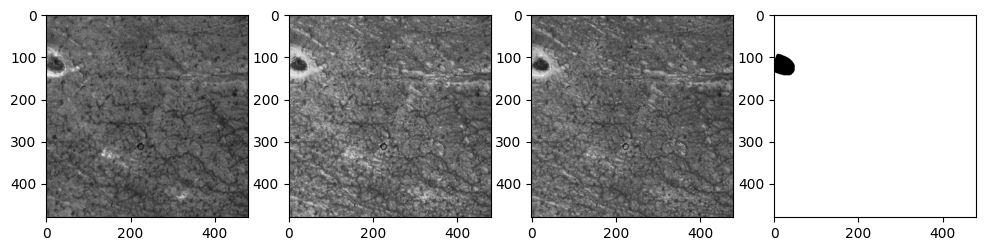

shape of augmented train data:  (41, 480, 480, 3)
shape of augmented label data:  (41, 480, 480, 1)
[0. 1.]


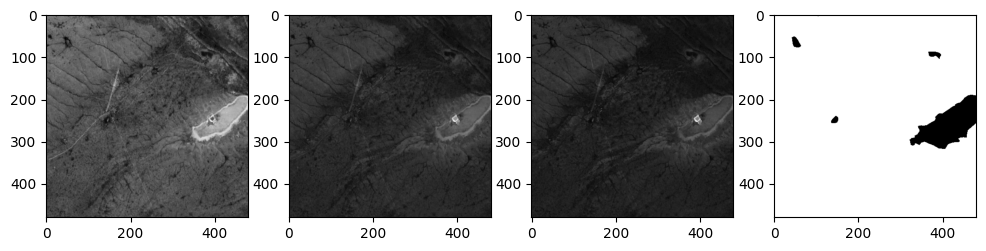

In [17]:
#@title dataset preparation

#train/vali split, augmentation, sanity check - paths, variables, execusion

## variables

split_random_state = 2 # do not change!

study_area = "kalahari" #@param["kalahari", "simpson"]

pans_rivers_choice = "pans" #@param["pans", "rivers", "none"]

test_size_number = 0.3 #@param{type: "number"}

#@markdown Which of the following datasets would you like to include?
sentinel = True #@param{type:"boolean"}
dem = False #@param{type:"boolean"}
curv = False #@param{type:"boolean"}
curv_smooth = False #@param{type:"boolean"}
dune_height = False #@param{type:"boolean"}
binary = False #@param{type:"boolean"}

#@markdown Would you like to sample data down to 30m res?
conduct_downsampling = False #@param{type:"boolean"}

#@markdown Conduct augmentation?
conduct_augmentation = False #@param{type:"boolean"}

batch_size_aug = 4 #@param{type:"integer"}

#@markdown rotation range - turn off: 0
rotation_range = 0 #@param {type:"slider", min:0, max:360, step:1}
#@markdown width shift range - turn off: 0
width_shift_range = 0.0 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
#@markdown height shift range - turn off: 0
height_shift_range = 0.0 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

#@markdown zooms - turn off: both 1.0
zoom_in = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
zoom_out = 1 #@param {type:"slider", min:1.0, max:2.0, step:0.1}
zoom_range = [zoom_in, zoom_out]

horizontal_flip = True #@param{type:"boolean"}
vertical_flip = True #@param{type:"boolean"}

# #@markdown brightness_range - turn off: both 1.0
# brightness_range_low = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
# brightness_range_high = 1.0 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
# brightness_range = [brightness_range_low, brightness_range_high]
brightness_range_decision = True #@param{type:"boolean"}
#brightness_range = (0.3, 1.0)
#brightness_range_values = [(0.3, 1.0), (0.3, 1.0), (0.3, 1.0), (0.3, 1.0)]

fill_mode = "constant" #@param["constant", "nearest", "reflect", "wrap"]

label_mask_threshold = 0.0 #@param{type:"slider", min:0.0, max:1.0, step:0.1}

#@markdown Save sanity check images?
sanity_check_save = False #@param{type:"boolean"}



## paths
if pans_rivers_choice == "none":
  LABELS_FOLDER_PATH = os.path.join(HOME_PATH_2, study_area, "pp_data", "train_pp", "labels")
else:
  LABELS_FOLDER_PATH = os.path.join(HOME_PATH_2, study_area, "pp_data", "train_pp", "labels", pans_rivers_choice)
TRAIN_FIG_FOLDER_PATH = os.path.join(HOME_PATH_2, "figures", date_today)
CSV_TRAIN_FILE_PATH = os.path.join(HOME_PATH_2, "csv", "train_images_info.csv")
CSV_VALI_FILE_PATH = os.path.join(HOME_PATH_2, "csv", "vali_images_info.csv")



## execution

# create list of datasets that will be included in training
list_paths_train_pp_img = create_training_dir_list(HOME_PATH_2,
                                                  study_area,
                                                  sentinel,
                                                  dem,
                                                  curv,
                                                  curv_smooth,
                                                  dune_height,
                                                  binary)

#print(list_paths_train_pp_img)

# gather data and split into training and validation
X_train, X_vali, y_train, y_vali = dataset_prep_split(list_paths_train_pp_img,
                                                      LABELS_FOLDER_PATH,
                                                      test_size_number,
                                                      split_random_state,
                                                      CSV_TRAIN_FILE_PATH,
                                                      CSV_VALI_FILE_PATH,
                                                      conduct_downsampling)

X_train_shape = X_train.shape
X_vali_shape = X_vali.shape

# augmentation
if conduct_augmentation:

  seed = 42 # do not change!!

  train_generator = augmentation(X_train,
                                 y_train,
                                 SEED,
                                 True,
                                 batch_size_aug,
                                 rotation_range,
                                 width_shift_range,
                                 height_shift_range,
                                 zoom_range,
                                 horizontal_flip,
                                 vertical_flip,
                                 brightness_range_decision,
                                 fill_mode,
                                 label_mask_threshold)



  vali_generator = augmentation(X_vali,
                                y_vali,
                                SEED,
                                False,
                                batch_size_aug,
                                rotation_range,
                                width_shift_range,
                                height_shift_range,
                                zoom_range,
                                horizontal_flip,
                                vertical_flip,
                                brightness_range_decision,
                                fill_mode,
                                label_mask_threshold)
  # ! vali_generator doesn't need augmentation settings if on False, but function needs it





# sanity check of training and validation data


if conduct_augmentation:
  sanity_check_yes_augmentation(train_generator, vali_generator, TRAIN_FIG_FOLDER_PATH, sanity_check_save)

else:
  train_generator = None
  vali_generator = None
  sanity_check_no_augmentation(X_train, y_train, X_vali, y_vali, TRAIN_FIG_FOLDER_PATH, sanity_check_save)

In [20]:
# @title load model and train - paths, variables, execution {"form-width":"30%"}

## variables

#@markdown metric can be "iou_metric", "binary_iou", "tiou_metric", "false_positive_metric"

learning_rate = "schedule" #@param[0.001, 0.0001, 0.00001, "schedule"]

loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=False)

activation_1 = "relu"
activation_2 = "sigmoid"

tile_size = 480 #@param{type:"integer"}
band_nr = 3 #@param{type:"integer"}

shuffle = False #@param{type:"boolean"}

#epoch_monitor = "val_tiou_metric" #@param["val_tiou_metric", "val_binary_iou", "val_loss"]
epoch_patience = 60 #@param{type:"integer"}

#warm-up epochs before early stopping starts
start_from_epoch = 1 #@param{type:"integer"}
early_stopping_mode = "max" #@param["auto", "min", "max"]
#monitor_bestweight = "val_tiou_metric" #@param["val_tiou_metric", "val_binary_iou", "val_loss"]
mode_bestweight = "max" #@param["auto", "min", "max"]

#@markdown Using finetuning (pre-trained model)?
load_pre_trained_weights = False #@param{type:"boolean"}
pre_trained_weights_filename = "best_model.keras"
#@markdown experiment of finetune model to use
finetune_experiment_id = "blabla" #@param{type:"boolean"}

wandb_project_name = "paper-3-resnet" #@param{type:"string"}

#@markdown Metric can be "iou_metric", "binary_iou", "tiou_metric", "false_positive_metric"

#@markdown Calculate 6 IoU types?
tiou_extended = False #@param{type:"boolean"}

evaluation_model = "last_model" #@param["best_model", "last_model"]



########## LOOP ##########

#lrs = [0.01, 0.001]
#bs = [2, 4, 8, 16]
#mts = ["unet_small", "unet_large"]
#prth = [0.4]
#mtr = ["binary_iou"]
#epnr = [100, 150]

# lrs = [0.01, 0.0001]
# bs = [8, 16]
# mts = ["unet_small", "unet_large"]
# prth = [0.5]
# mtr = ["binary_iou"]
# epnr = [150, 200]


lrs = [0.001, 0.0001]
bs = [4, 8]
mts = ["unet_model_resnet"]
prth = [0.5]
mtr = ["binary_iou"]
epnr = [200]



for initial_learning_rate, batch_size, model_type, prediction_threshold, metric, epoch_nr in list(it.product(lrs, bs, mts, prth, mtr, epnr)):

  print("loop started.")

  if initial_learning_rate == 5.0:
    continue


  # if initial_learning_rate == 0.01 and batch_size == 8 and model_type == "unet_small":
  #   continue

  else:

    epoch_patience = epoch_nr

    if metric == "tiou_metric":
      epoch_monitor = "val_tiou_metric"
      monitor_bestweight = "val_tiou_metric"

    if metric == "binary_iou":
      epoch_monitor = "val_binary_iou"
      monitor_bestweight = "val_binary_iou"

    train_accuracy_metric = metric
    val_accuracy_metric = f"val_{metric}"

    date_time_today = datetime.now().strftime("%Y-%m-%d-%H-%M")

    ## generate random letters

    def generate_random_letters(length=4):
      letters = string.ascii_letters  # includes both lowercase and uppercase letters
      return ''.join(random.choice(letters) for _ in range(length))

    random_letters = generate_random_letters()

    ## learning rate scheduling
    if learning_rate == "schedule":

      num_steps = ((len(X_train) // batch_size) + 1) * epoch_nr
      warmup_ratio = 0.1
      warmup_target = None #0.001
      #initial_learning_rate = 0.001 #warmup_target * 0.01
      decay_steps = (1 - warmup_ratio) * num_steps
      warmup_steps = None #warmup_ratio * num_steps

      learning_rate_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps, alpha=0.0, warmup_steps=warmup_steps, warmup_target=warmup_target)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)


    ########## TRAINING ##########


    ## load model

    def get_model():
      print("getting model started.")
      if model_type == "unet_small":
        return unet_model_small(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)
      elif model_type == "unet_medium":
        return unet_model_medium(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)
      elif model_type == "unet_large":
        return unet_model_large(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)
      elif model_type == "unet_model_resnet":
        return unet_model_resnet(tile_size, tile_size, band_nr, SEED, optimizer, metric, prediction_threshold)
      model.summary()


    ## wandb initialisation
    print("Check before wandb init")
    wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project=wandb_project_name,
        name=f"{date_time_today}_{wandb_project_name}_{random_letters}_duneminds_exp",
        config={
            "epochs": epoch_nr,
            "conduct_augmentation": conduct_augmentation,
            "batch_size_aug": batch_size_aug,
            "learning_rate": str(learning_rate),
            "X_train_shape": X_train_shape,
            "sentinel_used": sentinel,
            "dem_used": dem,
            "curv_used": curv,
            "curv_smooth_used": curv_smooth,
            "dune_height_used": dune_height,
            "rotation_range": rotation_range,
            "width_shift_range": width_shift_range,
            "height_shift_range": height_shift_range,
            "zoom_in": zoom_in,
            "zoom_out": zoom_out,
            "horizontal_flip": horizontal_flip,
            "vertical_flip": vertical_flip,
            "brightness_range_decision": brightness_range_decision,
            "fill_mode": fill_mode,
            "label_mask_threshold": label_mask_threshold,
            "batch_size": batch_size,
            "model_type": model_type,
            "optimizer": str(optimizer),
            "loss": str(loss),
            "metric": str(metric),
            "activation_1": activation_1,
            "activation_2": activation_2,
            "fine_tuning_decision": load_pre_trained_weights,
            "epoch_monitor": epoch_monitor,
            "epoch_patience": epoch_patience,
            "start_from_epoch": start_from_epoch,
            "early_stopping_mode": early_stopping_mode,
            "monitor_bestweight": monitor_bestweight,
            "prediction_threshold": prediction_threshold,
            "initial_learning_rate": initial_learning_rate,
            "learning_rate_schedule": str(learning_rate_schedule)
            }
        )
    print("Check after wandb init")

    ## paths

    EXPERIMENT_FOLDER_PATH = os.path.join(HOME_PATH_2, "experiments", f"{date_time_today}_{wandb_project_name}_{random_letters}_duneminds_exp")
    WEIGHTS_FOLDER_PATH = EXPERIMENT_FOLDER_PATH
    #weight_filename = f"{date_time_today}_{model_type}_weights.keras"
    #weight_filename_lastepoch = f"{date_time_today}_{model_type}_last_weights.keras"
    MODEL_FILES_FOLDER_PATH = EXPERIMENT_FOLDER_PATH
    model_filename = "best_model.keras"
    CONFIG_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "config.json")
    HISTORY_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "history.json")
    LOSS_FIGURE_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "LOSS.png")
    ACC_FIGURE_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, "ACC.png")
    FINETUNE_MODEL_FOLDER_PATH = os.path.join(HOME_PATH_2, "experiments", finetune_experiment_id)


    model = get_model()


    ## training

    model, history = training_model(load_pre_trained_weights,
                    epoch_monitor,
                    epoch_patience,
                    start_from_epoch,
                    early_stopping_mode,
                    monitor_bestweight,
                    mode_bestweight,
                    conduct_augmentation,
                    model,
                    X_train,
                    y_train,
                    batch_size,
                    epoch_nr,
                    X_vali,
                    y_vali,
                    shuffle,
                    train_generator,
                    vali_generator,
                    MODEL_FILES_FOLDER_PATH,
                    FINETUNE_MODEL_FOLDER_PATH)


    ## saving config


    with open(CONFIG_FILE_PATH, "w") as fh:
      json.dump({
          "seed":SEED,
          "train_study_area": study_area,
          "split_random_state": split_random_state,
          "train_dataset_list": list_paths_train_pp_img,
          "X_train_shape": X_train_shape,
          "X_vali_shape": X_vali_shape,
          "sentinel_used": sentinel,
          "dem_used": dem,
          "curv_used": curv,
          "curv_smooth_used": curv_smooth,
          "dune_height_used": dune_height,
          "test_size_number": test_size_number,
          "conduct_augmentation": conduct_augmentation,
          "batch_size_aug": batch_size_aug,
          "rotation_range": rotation_range,
          "width_shift_range": width_shift_range,
          "height_shift_range": height_shift_range,
          "zoom_in": zoom_in,
          "zoom_out": zoom_out,
          "horizontal_flip": horizontal_flip,
          "vertical_flip": vertical_flip,
          "brightness_range_decision": brightness_range_decision,
          "fill_mode": fill_mode,
          "label_mask_threshold": label_mask_threshold,
          "train_tile_size": tile_size,
          "epoch_nr": epoch_nr,
          "shuffle": shuffle,
          "batch_size": batch_size,
          "model_type": model_type,
          "learning_rate": str(learning_rate),
          "optimizer": str(optimizer),
          "loss": str(loss),
          "metric": str(metric),
          "activation_1": activation_1,
          "activation_2": activation_2,
          "fine_tuning_decision": load_pre_trained_weights,
          "epoch_monitor": epoch_monitor,
          "epoch_patience": epoch_patience,
          "start_from_epoch": start_from_epoch,
          "early_stopping_mode": early_stopping_mode,
          "monitor_bestweight": monitor_bestweight,
          "prediction_threshold": prediction_threshold,
          "initial_learning_rate": initial_learning_rate,
          "learning_rate_schedule": str(learning_rate_schedule)
        },
        fh, indent=2, sort_keys=False
      )


    ## saving history

    with open(HISTORY_FILE_PATH, "w") as fh:
      json.dump(history.history, fh, indent=2, sort_keys=True)



    ########## EVALUATION ##########
    if evaluation_model == "best_model":
      model.load_weights(os.path.join(MODEL_FILES_FOLDER_PATH, "best_model.keras"))
    elif evaluation_model == "last_model":
      model.load_weights(os.path.join(MODEL_FILES_FOLDER_PATH, "last_model.keras"))

    iou4, iou5, iou6, tiou_list, num_epochs, best_epoch_loss, best_epoch_val_loss, best_epoch_acc, best_epoch_val_acc, average_precision, average_recall = evaluate_training(
                                                        model,
                                                        prediction_threshold,
                                                        X_vali,
                                                        y_vali,
                                                        history,
                                                        LOSS_FIGURE_FILE_PATH,
                                                        ACC_FIGURE_FILE_PATH,
                                                        tiou_extended,
                                                        train_accuracy_metric,
                                                        val_accuracy_metric)

    if tiou_extended:

      metrics = {
                  "iou/iou4": iou4,
                  "iou/iou5": iou5,
                  "iou/iou6": iou6,
                  "iou/tiou_1": tiou_list[0],
                  "iou/tiou_2": tiou_list[1],
                  "iou/tiou_3": tiou_list[2],
                  "iou/tiou_4": tiou_list[3],
                  "iou/tiou_5": tiou_list[4],
                  "best_epoch_loss": best_epoch_loss,
                  "best_epoch_val_loss": best_epoch_val_loss,
                  "best_epoch_acc": best_epoch_acc,
                  "best_epoch_val_acc": best_epoch_val_acc,
                  "average_precision": average_precision,
                  "average_recall": average_recall,
                  }

    else:

      metrics = {
                "best_epoch_val_loss": best_epoch_val_loss,
                "iou/iou4": iou4,
                "iou/iou5": iou5,
                "iou/iou6": iou6,
                "iou/tiou_1": tiou_list[0],
                "best_epoch_loss": best_epoch_loss,
                "best_epoch_val_loss": best_epoch_val_loss,
                "best_epoch_acc": best_epoch_acc,
                "best_epoch_val_acc": best_epoch_val_acc,
                "average_precision": average_precision,
                "average_recall": average_recall,
                }


    wandb.log({**metrics})
    wandb.finish()



loop started.
Check before wandb init


Check after wandb init
getting model started.
94765736/94765736 [==============================] - 5s 0us/step


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Created folder.
2/2 [==============================] - 2s 445ms/step
IoU Scores: {0.6: 0.5264511602079011, 0.5: 0.5152184516003165, 0.4: 0.49395031382001287}
(41, 480, 480, 1)
first tier value:  1.0
second tier value:  0.5
mean intersection_full:  0.02666476117886179
sum intersection_full:  251886
mean intersection_lim_1:  0.0018593326558265582
sum intersection_lim_1:  17564
mean intersection_lim_2:  0.001196434620596206
sum intersection_lim_2:  11302
mean union_tiered:  0.06428004319105692
sum union_tiered:  607215
IoU_tiered:  0.4530536959725962


wandb: WARNING Serializing object of type ndarray that is 37785760 bytes
wandb: WARNING Serializing object of type ndarray that is 37785760 bytes


ROC,▁▄▄▆▆▆▆▇▇▇██████████████████████████████
average_precision,▁
average_recall,▁
best_epoch_acc,▁
best_epoch_loss,▁
best_epoch_val_acc,▁
best_epoch_val_loss,▁
binary_iou,▁▂▃▃▃▄▄▅▆▅▇▇▇▇████████████████████▇█████
binary_iou_0.3,▁▁▁▂▂▂▄▅▅▆▆▆▆▇▇▇▆▇██████████████████████
binary_iou_0.4,▁▁▃▁▃▄▅▄▄▄▆▇▇▇▇▇▇██▇████▇███████████████
binary_iou_0.6000000000000001,▁▁▃▃▄▄▁▅▆▆▇▆▇▇▇█▇▇██████████████████████


loop started.
Check before wandb init


Check after wandb init
getting model started.
Created folder.
2/2 [==============================] - 2s 451ms/step
IoU Scores: {0.6: 0.5852060985337451, 0.5: 0.5853545970762354, 0.4: 0.5777725093393301}
(41, 480, 480, 1)
first tier value:  1.0
second tier value:  0.5
mean intersection_full:  0.02691596798780488
sum intersection_full:  254259
mean intersection_lim_1:  0.001876587906504065
sum intersection_lim_1:  17727
mean intersection_lim_2:  0.001216971544715447
sum intersection_lim_2:  11496
mean union_tiered:  0.05381626863143631
sum union_tiered:  508370
IoU_tiered:  0.5463225603399099


wandb: WARNING Serializing object of type ndarray that is 37785760 bytes
wandb: WARNING Serializing object of type ndarray that is 37785760 bytes


ROC,▁▅▇▇████████████████████████████████████
average_precision,▁
average_recall,▁
best_epoch_acc,▁
best_epoch_loss,▁
best_epoch_val_acc,▁
best_epoch_val_loss,▁
binary_iou,▁▂▄▄▃▆▆▇▆▇▇▇▇▇██████████████████████████
binary_iou_0.3,▁▄▄▄▅▆▆▆▆▇▆▇▇▇█▇████████████████████████
binary_iou_0.4,▂▁▄▄▄▅▅▆▆▆▇▇▇▇█▇████████████████████████
binary_iou_0.6000000000000001,▁▁▅▅▅▆▆▇▇▇▇▇▇███████████████████████████


loop started.
Check before wandb init


Check after wandb init
getting model started.
Created folder.
2/2 [==============================] - 2s 448ms/step
IoU Scores: {0.6: 0.6368727963113643, 0.5: 0.6415805314796884, 0.4: 0.63524904406569}
(41, 480, 480, 1)
first tier value:  1.0
second tier value:  0.5
mean intersection_full:  0.027170879911924118
sum intersection_full:  256667
mean intersection_lim_1:  0.001810425135501355
sum intersection_lim_1:  17102
mean intersection_lim_2:  0.0011320714769647697
sum intersection_lim_2:  10694
mean union_tiered:  0.049016556571815716
sum union_tiered:  463030
IoU_tiered:  0.6028032740859124


wandb: WARNING Serializing object of type ndarray that is 37785760 bytes
wandb: WARNING Serializing object of type ndarray that is 37785760 bytes


ROC,▁▅▇▇██████████████████████▇█████████████
average_precision,▁
average_recall,▁
best_epoch_acc,▁
best_epoch_loss,▁
best_epoch_val_acc,▁
best_epoch_val_loss,▁
binary_iou,▁▄▇▅▆▇▇██████████▇███████████▅█▆████████
binary_iou_0.3,▁▁▁▂▃▇▇█████████████████████████████████
binary_iou_0.4,▁▇▇█▇███████████████████████████▇███████
binary_iou_0.6000000000000001,▁▁▁▂▄▇▇▇▇████████████▇▇█████████████████


loop started.
Check before wandb init


Check after wandb init
getting model started.
Created folder.


2/2 [==============================] - 2s 448ms/step
IoU Scores: {0.6: 0.47328911708227217, 0.5: 0.4918030582914546, 0.4: 0.5081985832087522}
(41, 480, 480, 1)
first tier value:  1.0
second tier value:  0.5
mean intersection_full:  0.020641196646341464
sum intersection_full:  194985
mean intersection_lim_1:  0.0020139947493224932
sum intersection_lim_1:  19025
mean intersection_lim_2:  0.0013730098238482384
sum intersection_lim_2:  12970
mean union_tiered:  0.04553523035230352
sum union_tiered:  430144
IoU_tiered:  0.5126074058919804


wandb: WARNING Serializing object of type ndarray that is 37785760 bytes
wandb: WARNING Serializing object of type ndarray that is 37785760 bytes


ROC,▁▇▇█████████████████████████████████████
average_precision,▁
average_recall,▁
best_epoch_acc,▁
best_epoch_loss,▁
best_epoch_val_acc,▁
best_epoch_val_loss,▁
binary_iou,▁▃▆▆▇███████████████████████████████████
binary_iou_0.3,▁▃▃▅▆▇▇▇▇███████████████████████████████
binary_iou_0.4,▁▁▂▇▇███████████████████████████████████
binary_iou_0.6000000000000001,▁▂▃▅▆▅▇▇▇███████████████████████████████


# Visualising Validation Data

In [19]:
#@title visualising validation results of multiple models
'''
updated 5th May 2025
'''


## variables

wandb_project_name = "paper-3-resnet" #@param["downscale-hyperpar", "paper-3-resnet", "sentinel-hyperpar", "elevation-hyperpar", "mix-hyperpar", "paper-3-all", "paper-3-rivers"]
VALI_VIS_FIG_FOLDER_PATH = os.path.join(HOME_PATH_2, "experiments", wandb_project_name)

#@markdown Please determine thresholds and models directly in script.
list_thresholds = [0.4,
                   0.5,
                   0.6
                   ]

model_best_last = "last_model.keras" #@param["last_model.keras", "best_model.keras"]



model_name = "2025-05-10-06-37_paper-3-resnet_fLBc_duneminds_exp"

chosen_imgs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#(non) augmented
fig_title = "sentinel only" #@param{type:"string"}

# Set the default fontsize for all figures
plt.rcParams.update({'font.size': 23})

model_path = os.path.join(HOME_PATH_2, "experiments", model_name, model_best_last)
model = tf.keras.models.load_model(model_path)


def visualize_predictions_optimized(vali_img_array, vali_label_array, model, list_thresholds, vali_vis_fig_path, chosen_imgs, fig_title, model_best_last, model_name):
    num_images = len(chosen_imgs)
    num_columns = len(list_thresholds) + 3  # original, label, probability, thresholds
    fig, axes = plt.subplots(num_images, num_columns, figsize=(num_columns * 5, num_images * 6))
    fig.subplots_adjust(top=3.0)
    fig.suptitle(fig_title, fontsize=32, x=0.02, ha='left')

    # Make predictions only once
    probabilities_all = model.predict(vali_img_array)

    final_prediction5 = None

    for row_idx, img_idx in enumerate(chosen_imgs):
        image = vali_img_array[img_idx]

        # Convert to RGB if necessary
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image_rgb = np.stack([image[:, :, 2], image[:, :, 1], image[:, :, 0]], axis=-1)
        else:
            image_rgb = image

        axes[row_idx, 0].imshow(image_rgb, cmap="gray" if len(image.shape) == 2 else None)
        axes[row_idx, 0].set_title("original")
        axes[row_idx, 0].axis("off")

        cmap = mcolors.ListedColormap(['black', 'white'])
        axes[row_idx, 1].imshow(vali_label_array[img_idx], cmap=cmap)
        axes[row_idx, 1].set_title("label")
        axes[row_idx, 1].axis("off")

        # Show probability map (same for all thresholds)
        probabilities = probabilities_all[img_idx]
        axes[row_idx, 2].imshow(probabilities.squeeze(), cmap="gray")
        axes[row_idx, 2].set_title("pred: probability")
        axes[row_idx, 2].axis("off")

        # Thresholded predictions
        for col_offset, threshold in enumerate(list_thresholds):
            prediction = (probabilities > threshold).astype(np.uint8)
            if threshold == 0.5:
                final_prediction5 = prediction
            axes[row_idx, col_offset + 3].imshow(prediction.squeeze(), cmap="gray")
            axes[row_idx, col_offset + 3].set_title(f"pred: {threshold}")
            axes[row_idx, col_offset + 3].axis("off")

    # Save figure
    if model_best_last == "best_model.keras":
        vali_vis_fig_file = f"vali_vis_{model_name}_{list_thresholds[0]}-{list_thresholds[-1]}.png"
    else:
        vali_vis_fig_file = f"last_vali_vis_{model_name}_{list_thresholds[0]}-{list_thresholds[-1]}.png"

    fun_check_create_folder(vali_vis_fig_path)
    plt.tight_layout()
    plt.savefig(os.path.join(vali_vis_fig_path, vali_vis_fig_file))
    plt.show()
    plt.close()

    return final_prediction5


final_prediction5 = visualize_predictions_optimized(X_vali, y_vali, model, list_thresholds, VALI_VIS_FIG_FOLDER_PATH, chosen_imgs, fig_title, model_best_last, model_name)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title plot difference between label and prediction


label = y_vali[8]
prediction = final_prediction5

title_fig = "Sentinel-2 no augm. 30m x 30m 0.5" #@param{type:"string"}


print(label.shape)
print(prediction.shape)

# Set the default fontsize for all figures
plt.rcParams.update({'font.size': 15})


# Initialize result array with zeros
result = np.zeros_like(label)

# Find where both label and prediction have 1s
both_ones = (label == 1) & (prediction == 1)

# Find where only label has 1s
only_label = (label == 1) & (prediction == 0)

# Find where only prediction has 1s
only_pred = (label == 0) & (prediction == 1)

# Assign values based on the conditions
result[both_ones] = 3 #both
result[only_label] = 1 # only labels
result[only_pred] = 2 # only prediction

# Create result_all based on result array
result_all = np.zeros(result.shape, dtype=int)

# Map values from result to result_all

result_all[result == 1] = 1
result_all[result == 2] = 2
result_all[result == 3] = 3

print(result_all.shape)


## Plotting

# Define custom colors
colors = ["white", '#4492bb', '#c19774', "black"]

# Create a custom colormap with three colors
cmap_custom = ListedColormap(colors)

# Plotting with seaborn and matplotlib
plt.figure(figsize=(6, 6))
ax = sns.heatmap(result_all.squeeze(), cmap=cmap_custom, cbar=False)
#ax = sns.heatmap(prediction.squeeze(), cmap=cmap_custom, cbar=False)
plt.title(title_fig, pad=20)

# Add a frame around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')  # Set the color of the frame

# Remove x-axis and y-axis ticks and labels
plt.xticks([])
plt.yticks([])

plt.tight_layout(pad=3.0)  # Increase the pad value as needed

plt.show()

# Testing / Prediction

In [20]:
#@title SIMPLE prediction functions


def prediction(path_config, seed, path_model, path_overall_results, path_results, tile_size_test, prediction_threshold, path_test_img, train_id, input_tile_name, downsampling):

  ########## LOAD MODEL AND WEIGHTS ##########

  model = tf.keras.models.load_model(path_model)


  ########## PREPARE DATA ##########


  # create tile name for exporting
  output_tile_name = f"res_{input_tile_name}" # choose first list (0), file names should be the same across all lists

  if not downsampling:

    with rasterio.open(path_test_img) as src:
      img = src.read()
      crs = src.crs
      transform = src.transform

    img = np.transpose(img, (1,2,0))
    img = np.expand_dims(img, axis=0)

    width = tile_size_test
    height = tile_size_test



  elif downsampling:

    with rasterio.open(path_test_img, "r") as src:
      img_old = src.read()
      crs = src.crs
      #transform = src.transform
      profile = src.profile
      height = src.height // 3
      width = src.width // 3
      tile_size_test = height

      #downscaling
      img = src.read(
          out_shape=(src.count, height, width),
          resampling=Resampling.bilinear
      )

      transform = src.transform * src.transform.scale(
          (src.width // img.shape[-1]),
          (src.height // img.shape[-2])
      )
      print(f"transform: {transform}")

      profile.update(width=width, height=height, transform=transform)
      print(f"profile {profile}")


      img = np.transpose(img, (1,2,0))
      img = np.expand_dims(img, axis=0)




  ########## PREDICTION ##########


  ## check if there is a folder for result files
  fun_check_create_folder(path_overall_results)
  fun_check_create_folder(path_results)

  ## create prediction & save as geotiffs
  # print(test_dataset.shape)
  # for i in range(test_dataset.shape[0]): # go through required tiles & predict
  prediction_raw = model.predict(img)
  prediction = (model.predict(img) > prediction_threshold).astype(np.uint8)
  print('Prediction done for tile')
  print(prediction.shape)


  prediction_squeezed = np.squeeze(prediction, axis=0)

  prediction_reduced = prediction_squeezed.transpose((2,0,1))

  print(prediction_reduced.shape)



  # exporting - save prediction as geotiff
  with rasterio.open(os.path.join(path_results, output_tile_name),
                  'w',
                  driver='Gtiff',
                  width=width,
                  height=height,
                  count=1,
                  crs=crs,
                  transform=transform,
                  dtype='uint8' #used to be 'float32'
                  ) as test_img_result:

      # prediction_reduced = prediction_reduced.astype('uint8') # might compress data further?

    test_img_result.write(prediction_reduced)

  return prediction_raw

In [21]:
#@title FUSION prediction functions


########## create list of folders that will be part of training / validation data ##########

def create_test_dir_list(home_dir,
                        study_area_train,
                        include_sentinel,
                        include_dem,
                        include_curv,
                        include_curv_smooth,
                        include_dune_height,
                        tile_size,
                        part):

  selected_parameters = []
  list_paths_train_pp_img = []

  parameters = {
      "sentinel": include_sentinel,
      "dem": include_dem,
      "curv": include_curv,
      "curv_smooth": include_curv_smooth,
      "dune_height": include_dune_height
  }

  print(include_dem)

  for input_param, value in parameters.items():
    if value:
      selected_parameters.append(input_param)

  print(selected_parameters)

  if len(selected_parameters) > 4:
    sys.exit("Too many input data parameters selected. Cannot choose more than 4.")

  list_paths_train_pp_img = []
  for item in selected_parameters:
    paths_train_pp_img = os.path.join(home_dir, study_area_train, "pp_data", "test_pp", f"tiles_{tile_size}", item, part) # LIST of paths
    list_paths_train_pp_img.append(paths_train_pp_img)

  return list_paths_train_pp_img



def prediction_fusion(path_config,
                      seed,
                      path_model,
                      path_overall_results,
                      path_results,
                      tile_size_test,
                      prediction_threshold,
                      input_array,
                      train_id,
                      input_tile_name,
                      downsampling,
                      crs,
                      transform):

  ########## LOAD MODEL AND WEIGHTS ##########

  model = tf.keras.models.load_model(path_model)


  ########## PREPARE DATA ##########

  if not downsampling:
    # create tile name for exporting
    output_tile_name = f"res_fusion_{input_tile_name}" # choose first list (0), file names should be the same across all lists

    img = input_array
    img = np.expand_dims(img, axis=0)

  elif downsampling:
    print("To Do: Downsampling")


  ########## PREDICTION ##########


  ## check if there is a folder for result files
  fun_check_create_folder(path_overall_results)
  fun_check_create_folder(path_results)

  ## create prediction & save as geotiffs
  # print(test_dataset.shape)
  # for i in range(test_dataset.shape[0]): # go through required tiles & predict
  prediction_raw = model.predict(img)
  prediction = (model.predict(img) > prediction_threshold).astype(np.uint8)
  print('Prediction done for tile')
  print(prediction.shape)


  prediction_squeezed = np.squeeze(prediction, axis=0)

  prediction_reduced = prediction_squeezed.transpose((2,0,1))

  print(prediction_reduced.shape)



  # exporting - save prediction as geotiff
  with rasterio.open(os.path.join(path_results, output_tile_name),
                  'w',
                  driver='Gtiff',
                  width=tile_size_test,
                  height=tile_size_test,
                  count=1,
                  crs=crs,
                  transform=transform,
                  dtype='uint8' #used to be 'float32'
                  ) as test_img_result:

      # prediction_reduced = prediction_reduced.astype('uint8') # might compress data further?

    test_img_result.write(prediction_reduced)

  return prediction_raw

In [23]:
#@title test/prediction - variables & execution

#path_results_run, path_results, path_weights, weight_file, model, path_config, path_test_pp


########## variables ##########

# working: kalahari_tile_sentinel_9600_14400_img.tif
# not working: kalahari_tile_sentinel_14400_19200_img.tif

# mix dem no aug: 2024-04-09-08-35_mix-hyperpar-2_OhbV_duneminds_exp

# non-downsampled: 2024-03-29-08-47_sentinel-hyperpar-2_OhbV_duneminds_exp
# downsampled: 2024-04-09-17-05_downsample-hyperpar-2_OhbV_duneminds_exp

train_id = "2025-05-10-06-37_paper-3-resnet_fLBc_duneminds_exp" #@param{type:"string"}
#input_tile_name = "kalahari_tile_sentinel_14400_19200_img.tif" #@param{type:"string"}
#model_type_train = "unet_large" #@param["unet_small", "unet_medium", "unet_large"]
study_area_test = "kalahari" #@param["kalahari", "simpson"]
tile_size_test_data = 4800 #@param{type:"integer"}
data_type = "sentinel" #@param["fusion", "sentinel", "dem", "curv", "curv_smooth", "dune_height"]
sentinel = True #@param{type:"boolean"}
dem = False #@param{type:"boolean"}
curv = False #@param{type:"boolean"}
curv_smooth = False #@param{type:"boolean"}
dune_height = False #@param{type:"boolean"}
prediction_threshold = 0.5 #@param{type:"number"}
downsampling = False #@param{type: "boolean"}
weight_choice = "best_model" #@param["best_model", "last_model"]

part = "part_2" #@param["part_1", "part_2"]


########## paths ##########

EXPERIMENT_FOLDER_PATH = os.path.join(HOME_PATH_2, "experiments", f"{train_id}")

CONFIG_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, f"config.json")
TEST_FOLDER_PATH = os.path.join(HOME_PATH_2, study_area_test, "pp_data", "test_pp", f"tiles_{tile_size_test_data}", data_type, part)

if weight_choice == "best_model":
  MODEL_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, f"best_model.keras")
elif weight_choice == "last_model":
  MODEL_FILE_PATH = os.path.join(EXPERIMENT_FOLDER_PATH, f"last_model.keras")

OVERALL_RESULTS_FOLDER_PATH = os.path.join(HOME_PATH_2, "results", "final_pred_maps", f"{study_area_test}_{data_type}_{tile_size_test_data}")
RESULTS_FOLDER_PATH = os.path.join(OVERALL_RESULTS_FOLDER_PATH, train_id)

test_dir_list = create_test_dir_list(HOME_PATH_2,
                                    study_area_test,
                                    sentinel,
                                    dem,
                                    curv,
                                    curv_smooth,
                                    dune_height,
                                    tile_size_test_data,
                                    part)

print(test_dir_list)


if len(test_dir_list) >= 2:
  test_data, test_data_info = fun_concatenate_img(test_dir_list)
  print(test_data.shape)

  for i in range(test_data.shape[0]):
    test_array = test_data[i,:,:,:]
    print(f"test array shape: {test_array.shape}")
    print(test_data_info)
    input_tile_name = test_data_info[i][1] #1: which image, 2: 1 path or 2 img name
    input_tile_path = os.path.join(test_data_info[i][0], input_tile_name)

    with rasterio.open(input_tile_path) as src:
      crs = src.crs
      transform = src.transform

    print(f"tile name: {input_tile_name}")

    prediction_array = prediction_fusion(CONFIG_FILE_PATH,
                                  SEED,
                                  MODEL_FILE_PATH,
                                  OVERALL_RESULTS_FOLDER_PATH,
                                  RESULTS_FOLDER_PATH,
                                  tile_size_test_data,
                                  prediction_threshold,
                                  test_array,
                                  train_id,
                                  input_tile_name,
                                  downsampling,
                                  crs,
                                  transform)



elif len(test_dir_list) == 0:
  sys.exit("No data chosen.")

else:

  for file in sorted(os.listdir(test_dir_list[0])):
    if file.endswith('.tif'):
      print(file)
      input_tile_name = file
      path_test_img = os.path.join(test_dir_list[0], input_tile_name)

      prediction_array = prediction(CONFIG_FILE_PATH,
                                    SEED,
                                    MODEL_FILE_PATH,
                                    OVERALL_RESULTS_FOLDER_PATH,
                                    RESULTS_FOLDER_PATH,
                                    tile_size_test_data,
                                    prediction_threshold,
                                    path_test_img,
                                    train_id,
                                    input_tile_name,
                                    downsampling)


False
['sentinel']
['/content/drive/MyDrive/PAPER3_data/kalahari/pp_data/test_pp/tiles_4800/sentinel/part_2']
kalahari_tile_sentinel_0_14400_img.tif
Folder exists.
Folder exists.
1/1 [==============================] - 0s 190ms/step
Prediction done for tile
(1, 4800, 4800, 1)
(1, 4800, 4800)
kalahari_tile_sentinel_0_4800_img.tif
Folder exists.
Folder exists.
1/1 [==============================] - 0s 194ms/step
Prediction done for tile
(1, 4800, 4800, 1)
(1, 4800, 4800)
kalahari_tile_sentinel_0_9600_img.tif
Folder exists.
Folder exists.
1/1 [==============================] - 0s 191ms/step
Prediction done for tile
(1, 4800, 4800, 1)
(1, 4800, 4800)
kalahari_tile_sentinel_14400_0_img.tif
Folder exists.
Folder exists.
1/1 [==============================] - 0s 193ms/step
Prediction done for tile
(1, 4800, 4800, 1)
(1, 4800, 4800)
kalahari_tile_sentinel_14400_14400_img.tif
Folder exists.
Folder exists.
1/1 [==============================] - 0s 191ms/step
Prediction done for tile
(1, 4800, 480

In [ ]:
#@title checking tiles that are weird

study_area_test = "kalahari" #@param["kalahari", "simpson"]
tile_size_test_data = 4800 #@param{type:"integer"}

TEST_FOLDER_PATH = os.path.join(HOME_PATH, study_area_test, "pp_data", "test_pp", f"tiles_{tile_size_test_data}", "sentinel")
TRAIN_FOLDER_PATH = os.path.join(HOME_PATH, study_area_test, "pp_data", "train_pp", "sentinel")

tile_1 = "kalahari_tile_sentinel_19200_24000_img.tif"
tile_2 = "kalahari_tile_sentinel_19200_19200_img.tif" #bad
tile_3 = "kalahari_tile_sentinel_14400_24000_img.tif"
tile_4 = "kalahari_tile_sentinel_14400_19200_img.tif" #bad
tile_4 = "kalahari_tile_sentinel_14400_14400_img.tif"
tile_1_train = "kalahari_tile_sentinel_10176_12480_img.tif"
tile_2_train = "kalahari_tile_sentinel_16704_23616_img.tif"

path_tile_1 = os.path.join(TEST_FOLDER_PATH, tile_1)
path_tile_2 = os.path.join(TEST_FOLDER_PATH, tile_2)
path_tile_3 = os.path.join(TEST_FOLDER_PATH, tile_3)
path_tile_4 = os.path.join(TEST_FOLDER_PATH, tile_4)
path_tile_1_train = os.path.join(TRAIN_FOLDER_PATH, tile_1_train)
path_tile_2_train = os.path.join(TRAIN_FOLDER_PATH, tile_2_train)

list_tile_paths = [path_tile_1, path_tile_2, path_tile_3, path_tile_4, path_tile_1_train, path_tile_2_train]



bands_data = [[] for _ in range(4)]

for path in list_tile_paths:
  with rasterio.open(path) as src:
    img = src.read()

    # if path == path_tile_1_train or path == path_tile_2_train:
    #   img_show = img.transpose(1,2,0)
    #   plt.imshow(img_show)
    #   plt.show()

    # Collect data for each band
    for band_idx in range(4):
      bands_data[band_idx].append(img[band_idx].flatten())

# Plot boxplots for each band
plt.figure(figsize=(12, 8))
band_names = ['Band 1', 'Band 2', 'Band 3', 'Band 4']

for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.boxplot(bands_data[i], patch_artist=True)
  plt.title(f'{band_names[i]}')
  plt.xlabel('Tiles')
  plt.ylabel('Pixel Values')

plt.tight_layout()
plt.show()

    # print(img.shape)
    # print(f"min: {np.min(img)}")
    # print(f"25th perc: {np.percentile(img, 25)}")
    # print(f"median: {np.median(img)}")
    # print(f"average: {np.mean(img)}")
    # print(f"75th perc: {np.percentile(img, 75)}")
    # print(f"max: {np.max(img)}")



# Other

In [ ]:
#@title create resnet compatible TRAINING images

# Define your source and destination folders
folder_A = os.path.join(HOME_PATH_2, "kalahari", "pp_data", "train_pp", "sentinel_pans") # Folder with original B-G-R-NIR .tif images
folder_B = os.path.join(HOME_PATH_2, "kalahari", "pp_data", "train_pp", "sentinel")  # Folder to save R-G-B images

# Create destination folder if it doesn't exist
os.makedirs(folder_B, exist_ok=True)

# === ImageNet mean/std for R-G-B ===
imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
imagenet_std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

# === Process each .tif file ===
for filename in os.listdir(folder_A):
    if filename.lower().endswith('.tif'):
        src_path = os.path.join(folder_A, filename)
        dst_path = os.path.join(folder_B, filename)

        with rasterio.open(src_path) as src:
            data = src.read()  # Shape: (4, H, W)

            if data.shape[0] != 4:
                print(f"Skipping {filename}: does not have 4 channels")
                continue

            # Rearrange to R-G-B (channels 2, 1, 0)
            rgb = data[[2, 1, 0], :, :].astype(np.float32)

            # Apply ImageNet normalization
            rgb = (rgb - imagenet_mean) / imagenet_std

            # Update metadata
            profile = src.profile
            profile.update({
                'count': 3,
                'dtype': 'float32'  # Float32 after normalization
            })

            # Save the normalized image
            with rasterio.open(dst_path, 'w', **profile) as dst:
                dst.write(rgb)

print("✅ Done: Normalized R-G-B images saved with geocoding preserved.")


In [ ]:
#@title create resnet compatible TEST images

# Define your source and destination folders
folder_A = os.path.join(HOME_PATH_2, "kalahari", "pp_data", "test_pp", "tiles_4800", "sentinel_unet", "part_2") # Folder with original B-G-R-NIR .tif images
folder_B = os.path.join(HOME_PATH_2, "kalahari", "pp_data", "test_pp", "tiles_4800", "sentinel", "part_2")  # Folder to save R-G-B images

# Create destination folder if it doesn't exist
os.makedirs(folder_B, exist_ok=True)

# === ImageNet mean/std for R-G-B ===
imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
imagenet_std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

# === Process each .tif file ===
for filename in os.listdir(folder_A):
    if filename.lower().endswith('.tif'):
        src_path = os.path.join(folder_A, filename)
        dst_path = os.path.join(folder_B, filename)

        with rasterio.open(src_path) as src:
            data = src.read()  # Shape: (4, H, W)

            if data.shape[0] != 4:
                print(f"Skipping {filename}: does not have 4 channels")
                continue

            # Rearrange to R-G-B (channels 2, 1, 0)
            rgb = data[[2, 1, 0], :, :].astype(np.float32)

            # Apply ImageNet normalization
            rgb = (rgb - imagenet_mean) / imagenet_std

            # Update metadata
            profile = src.profile
            profile.update({
                'count': 3,
                'dtype': 'float32'  # Float32 after normalization
            })

            # Save the normalized image
            with rasterio.open(dst_path, 'w', **profile) as dst:
                dst.write(rgb)

print("✅ Done: Normalized R-G-B images saved with geocoding preserved.")


✅ Done: Normalized R-G-B images saved with geocoding preserved.
